#1. Introduction

This colab provides the code for Crossvalidation to asses the performance of the RoBERTa Large model. This version is **stable**. The files you will need for this colab are "PETv1.1-entities.jsonl" and "complete_combined_leschneiderdata_NER.jsonl". The paths of which you need to specify.

##1.1 Preliminary Code

The code below provides the necesary libraries, paths to the input data and initial variable setups.

In [ ]:
#@title Importing and setting variables
import torch
import json
from transformers import BertTokenizer, BertForTokenClassification
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import RobertaTokenizer, RobertaForTokenClassification
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from collections import defaultdict
from sklearn.metrics import precision_recall_fscore_support
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from google.colab import files
import random
import copy

# Set a fixed seed for all random operations
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# If you're using CUDA:
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # For multi-GPU setups
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


drive.mount('/content/drive/')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#setting up the tokenizer
#tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
tokenizer = RobertaTokenizer.from_pretrained("roberta-large")

#Is needed for the translation between floats and labels, as BERT's output is a float.
label_map = {
    "O": 0,
    "B-Actor": 1, "I-Actor": 2,
    "B-Activity": 3, "I-Activity": 4,
    "B-Activity Data": 5, "I-Activity Data": 6,
    "B-Further Specification": 7, "I-Further Specification": 8,
    "B-XOR Gateway": 9, "I-XOR Gateway": 10,
    "B-Condition Specification": 11, "I-Condition Specification": 12,
    "B-AND Gateway": 13, "I-AND Gateway": 14
}

short_label_map = {
    "O": 0,
    "Actor": 1,
    "Activity": 2,
    "Activity Data": 3,
    "Further Specification": 4,
    "XOR Gateway": 5,
    "Condition Specification": 6,
    "AND Gateway": 7
}

# Reverse map for evaluation purposes
reverse_label_map = {v: k for k, v in label_map.items()}
NUM_LABELS = len(label_map)  # Correctly reflects the actual classification labels


Mounted at /content/drive/


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

In [ ]:
# Constants, can be changed for model optimisation
MAX_LEN = 128
BATCH_SIZE = 8
EPOCHS = 7

In [ ]:
#@title Printing Model Output Code
def print_token_predictions_true_labels(val_dataloader, model, tokenizer, reverse_label_map, num_samples=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()  # Ensure the model is in evaluation mode
    samples_printed = 0

    for batch in val_dataloader:
        if samples_printed >= num_samples:
            break  # Stop once we've reached the desired number of samples

        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            logits = outputs.logits

        # Convert logits to predicted label IDs
        preds = torch.argmax(logits, dim=2)

        for i in range(batch['input_ids'].size(0)):
            if samples_printed >= num_samples:
                break

            input_ids = batch['input_ids'][i].cpu().numpy()
            attention_mask = batch['attention_mask'][i].cpu().numpy()
            true_label_ids = batch['labels'][i].cpu().numpy()
            pred_label_ids = preds[i].cpu().numpy()

            # Decode the input IDs to tokens
            tokens = tokenizer.convert_ids_to_tokens(input_ids, skip_special_tokens=False)

            # Skip special tokens for true and predicted labels
            true_labels = [reverse_label_map[label_id] for label_id, mask in zip(true_label_ids, attention_mask) if mask == 1]
            pred_labels = [reverse_label_map[pred_id] for pred_id, mask in zip(pred_label_ids, attention_mask) if mask == 1]

            print(f"\nSample {samples_printed + 1}:")
            print("Tokens and Labels:")
            for token, true_label, pred_label in zip(tokens, true_labels, pred_labels):
                print(f"{token}\tTrue: {true_label}\tPred: {pred_label}")
            print("\n")

            samples_printed += 1


def print_token_true_labels_per_sentence_excluding_special_tokens(val_dataloader, model, tokenizer, reverse_label_map, num_samples=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device).eval()  # Move model to the correct device and set to evaluation mode

    samples_printed = 0

    for batch in val_dataloader:
        if samples_printed >= num_samples:
            break  # Stop after reaching the desired number of samples

        batch = {k: v.to(device) for k, v in batch.items()}  # Move batch to the correct device

        with torch.no_grad():
            outputs = model(**batch)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=2)

        for i in range(batch['input_ids'].size(0)):
            if samples_printed >= num_samples:
                break

            input_ids = batch['input_ids'][i].cpu().numpy()
            attention_mask = batch['attention_mask'][i].cpu().numpy()
            true_label_ids = batch['labels'][i].cpu().numpy()

            tokens = tokenizer.convert_ids_to_tokens(input_ids, skip_special_tokens=True)
            true_labels = [reverse_label_map[label_id] for label_id in true_label_ids]

            # Filter tokens and labels to exclude special tokens and corresponding labels
            filtered_tokens_and_labels = [
                (token, label) for token, label, mask in zip(tokens, true_labels, attention_mask)
                if mask == 1 and token not in tokenizer.all_special_tokens
            ]

            filtered_tokens = [token for token, _ in filtered_tokens_and_labels]
            filtered_true_labels = [label for _, label in filtered_tokens_and_labels]

            print(f"\nSample {samples_printed + 1}:")
            print("Tokens:")
            print(filtered_tokens)
            print("True Labels:")
            print(filtered_true_labels)
            print("\n")

            samples_printed += 1

# Ensure you have your val_dataloader, model, tokenizer, and reverse_label_map properly defined before calling this function.

def output_predictions_to_excel(val_dataloader, model, tokenizer, reverse_label_map, num_samples=5, file_name='output.xlsx'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device).eval()  # Ensure the model is in evaluation mode and moved to the right device
    samples_printed = 0

    # Prepare DataFrame
    columns = ['Token', 'True Label', 'Predicted Label']
    data = []

    for batch in val_dataloader:
        #if samples_printed >= num_samples:
            #break  # Stop once we've reached the desired number of samples

        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            logits = outputs.logits
        preds = torch.argmax(logits, dim=2)

        for i in range(batch['input_ids'].size(0)):
            #if samples_printed >= num_samples:
                #break

            input_ids = batch['input_ids'][i].cpu().numpy()
            attention_mask = batch['attention_mask'][i].cpu().numpy()
            true_label_ids = batch['labels'][i].cpu().numpy()
            pred_label_ids = preds[i].cpu().numpy()

            tokens = tokenizer.convert_ids_to_tokens(input_ids, skip_special_tokens=False)
            true_labels = [reverse_label_map[label_id] for label_id, mask in zip(true_label_ids, attention_mask) if mask == 1]
            pred_labels = [reverse_label_map[pred_id] for pred_id, mask in zip(pred_label_ids, attention_mask) if mask == 1]

            # Append each token and its labels to the data list
            data.extend([(token, true, pred) for token, true, pred in zip(tokens, true_labels, pred_labels)])

            samples_printed += 1

    # Create DataFrame and write to Excel
    file_path = f"/content/drive/MyDrive/THESIS/CODING/BERT outputs/BERT predictions/{file_name}"
    df = pd.DataFrame(data, columns=columns)
    df.to_excel(file_path, index=False)

    print(f"Output written to {file_path}")

In [ ]:
#@title Initialization of necessary functions for crossvalidation and training of BERT

#This function is grouping and loading data per doc-id such that they are processed per doc-id. The function expects a path to a .json file
def load_and_group_ner_data(file_path):
    grouped_data = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            entry = json.loads(line)
            document_name = entry['document name']  # Adjusted to use 'document name'
            if document_name not in grouped_data:
                grouped_data[document_name] = []
            grouped_data[document_name].append(entry)
            #print(entry)
    # Sort each group by 'sentence-ID'
    for doc in grouped_data.values():
        doc.sort(key=lambda x: x['sentence-ID'])

    return list(grouped_data.values())

#For the calculation of accuracy metrics
def calculate_f1(model, dataloader, device):
    model.eval()
    true_labels, pred_labels = [], []
    with torch.no_grad():
        check_true, check_pred = set(), set()
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)



            # Flatten labels and predictions
            batch_labels = batch['labels'].detach().cpu().numpy()
            batch_predictions = predictions.detach().cpu().numpy()

            true_labels.extend(batch_labels.flatten())
            pred_labels.extend(batch_predictions.flatten())
            check_true.update(true_labels)
            check_pred.update(pred_labels)


    # Calculate precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted', zero_division=0)
    return precision, recall, f1


#This class tokenizes the sentences and their words according to the predefined tokenizer for BERT. Also maps the labels to their integer number values.
class NERDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_len, label_map):
        self.sentences = sentences  # List of sentences (each sentence is a list of words)
        self.labels = labels        # List of label sequences corresponding to each sentence
        self.tokenizer = tokenizer  # BERT tokenizer
        self.max_len = max_len      # Maximum sequence length
        self.label_map = label_map  # Mapping from label strings to integers

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        words = self.sentences[idx]
        word_labels = self.labels[idx]

        # Tokenize words and align labels with tokens
        tokens = []
        aligned_labels = []
        for word, label in zip(words, word_labels):
            word_tokens = self.tokenizer.tokenize(word)
            tokens.extend(word_tokens)
            # Extend the label to all subwords
            aligned_labels.extend([label] * len(word_tokens))

        # Truncate tokens and labels if they exceed max_len
        tokens = tokens[:self.max_len-2]
        aligned_labels = aligned_labels[:self.max_len-2]

        # Convert tokens and labels to model inputs
        input_ids = self.tokenizer.convert_tokens_to_ids(['[CLS]'] + tokens + ['[SEP]'])
        attention_mask = [1] * len(input_ids)
        label_ids = [self.label_map['O']] + [self.label_map[label] for label in aligned_labels] + [self.label_map['O']]

        # Padding
        padding_length = self.max_len - len(input_ids)
        input_ids += [self.tokenizer.pad_token_id] * padding_length
        attention_mask += [0] * padding_length
        label_ids += [self.label_map['O']] * padding_length

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'labels': torch.tensor(label_ids, dtype=torch.long)
        }

#This function employs a BERT model training where no early stopping is used
def train_model(model, train_dataloader, val_dataloader, optimizer, scheduler, EPOCHS, label_map, checkpoint_dir='./model_checkpoints'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Directory where you want to save your model checkpoints
    os.makedirs(checkpoint_dir, exist_ok=True)

    #Initialize score
    best_f1_score = 0.0

    #In order to plot the validation and training losses to check for overfitting
    training_losses = []
    validation_losses = []

    for epoch_i in range(EPOCHS):
        print(f'Epoch {epoch_i + 1}/{EPOCHS}')
        print("Training...")
        model.train()
        total_train_loss = 0

        for step, batch in enumerate(train_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            model.zero_grad()
            try:
                outputs = model(**batch)
                loss = outputs.loss
                loss.backward()
                optimizer.step()
                scheduler.step()
            except RuntimeError as e:
                print(f"Error at step {step} in epoch {epoch_i}: {e}")
                print(f"Batch: {batch}")
                raise
            total_train_loss += loss.item()

            if step % 100 == 0 or step == len(train_dataloader) - 1:
                precision, recall, f1 = calculate_f1(model, val_dataloader, device)
                print(f"Step {step}, Loss: {loss.item():.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

        avg_train_loss = total_train_loss / len(train_dataloader)
        print(f'Average training loss: {avg_train_loss:.4f}\n')

        training_losses.append(avg_train_loss)

        # In each epoch we validate the current model so to get the Validation Loss for plotting.
        val_metrics = evaluate_model(model, val_dataloader, label_map)
        validation_losses.append(val_metrics['avg_val_loss'])

    return model, training_losses, validation_losses

#This function employs a BERT model training where early stopping is used
def train_model_with_early_stopping(model, train_dataloader, val_dataloader, optimizer, scheduler, EPOCHS, patience, checkpoint_dir='./model_checkpoints'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    os.makedirs(checkpoint_dir, exist_ok=True)
    best_f1_score = 0.0
    patience_counter = 0

    for epoch_i in range(EPOCHS):
        print(f'Epoch {epoch_i + 1}/{EPOCHS}')
        model.train()
        total_train_loss = 0

        for step, batch in enumerate(train_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            model.zero_grad()
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            total_train_loss += loss.item()
            optimizer.step()
            scheduler.step()

        precision, recall, f1 = calculate_f1(model, val_dataloader, device)
        print(f"Epoch {epoch_i + 1}, Validation Precision: {precision}, Recall: {recall}, F1: {f1}")

        if f1 > best_f1_score:
            best_f1_score = f1
            patience_counter = 0
            torch.save(model.state_dict(), os.path.join(checkpoint_dir, 'best_model.pth'))
            print("Validation F1 Score improved. Saving model checkpoint.")
        else:
            patience_counter += 1
            print("Validation F1 Score did not improve.")

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

        print(f'Epoch {epoch_i + 1} completed.\n')

    # Load the best model after training ends
    model.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'best_model.pth')))

In [ ]:
#@title convert_IOB2_to_chunks
def convert_IOB2_to_chunks(nested_label_list, reverse_label_map):

    all_chunks = []
    #print(nested_label_list)
    for sentence in nested_label_list:
        #print(sentence)
        chunks = []
        current_chunk = []
        current_type = None

        for idx, label_idx in enumerate(sentence):
            label = reverse_label_map[label_idx]

            if label.startswith('B-'):
                if current_chunk:
                    chunks.append((current_type, current_chunk))
                    current_chunk = []
                current_type = label[2:]
                current_chunk = [idx, idx]  # Start a new chunk

            elif label.startswith('I-') and current_type == label[2:]:
                current_chunk[1] = idx  # Extend the current chunk

            elif label == 'O':
                if current_chunk:  # End current chunk before starting 'O' chunk
                    chunks.append((current_type, current_chunk))
                current_type = 'O'
                current_chunk = [idx, idx]  # Start a new 'O' chunk immediately


            else:  # For non-matching 'I-' or different entity types
                if current_chunk:
                    chunks.append((current_type, current_chunk))
                    current_chunk = []
                current_type = None

        if current_chunk:  # Add the last chunk if exists
            chunks.append((current_type, current_chunk))

        all_chunks.append(chunks)

    return all_chunks

In [ ]:
#@title Evaluation helper functions
def calculate_metrics_per_sentence_by_label(true_chunks_all_sentences, pred_chunks_all_sentences):
    # Initialize counters for true positives, false positives, and false negatives per label
    tp_dict = defaultdict(int)
    fp_dict = defaultdict(int)
    fn_dict = defaultdict(int)
    support_dict = defaultdict(int)


    labels = set(label for sentence in true_chunks_all_sentences + pred_chunks_all_sentences for label, _ in sentence)

    #For the calculation of support
    for true_chunks in true_chunks_all_sentences:
        for label, _ in true_chunks:
            support_dict[label] += 1

    #For the calculation of precision, recall and F1
    for true_chunks, pred_chunks in zip(true_chunks_all_sentences, pred_chunks_all_sentences):
        true_set = set((label, tuple(indices)) for label, indices in true_chunks)
        pred_set = set((label, tuple(indices)) for label, indices in pred_chunks)

        # True Positives per label
        for label, indices in true_set & pred_set:
            tp_dict[label] += 1

        # False Positives per label
        for label, indices in pred_set - true_set:
            fp_dict[label] += 1

        # False Negatives per label
        for label, indices in true_set - pred_set:
            fn_dict[label] += 1

    # Calculate metrics per label
    metrics_per_label = {}
    for label in labels:
        tp = tp_dict[label]
        fp = fp_dict[label]
        fn = fn_dict[label]
        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
        support = support_dict[label]

        metrics_per_label[label] = {
            "Precision": precision,
            "Recall": recall,
            "F1": f1,
            "Support": support,
            "TP": tp,
            "FP": fp,
            "FN": fn
        }

    return metrics_per_label

def calculate_macro_averaged_f1(metrics_per_label):
    f1_scores = [metrics['F1'] for metrics in metrics_per_label.values()]
    macro_averaged_f1 = sum(f1_scores) / len(f1_scores) if f1_scores else 0
    return macro_averaged_f1

def calculate_micro_f1(metrics_per_label):
    # Initialize counters for total TP, FP, and FN
    total_tp = 0
    total_fp = 0
    total_fn = 0

    # Iterate through each label in the metrics_per_label dictionary
    for label, metrics in metrics_per_label.items():
        # Extract the TP, FP, and FN for the current label
        tp = metrics["TP"]
        fp = metrics["FP"]
        fn = metrics["FN"]

        # Accumulate the total TP, FP, and FN
        total_tp += tp
        total_fp += fp
        total_fn += fn

    # Calculate micro precision and recall
    if (total_tp + total_fp) > 0:
        micro_precision = total_tp / (total_tp + total_fp)
    else:
        micro_precision = 0

    if (total_tp + total_fn) > 0:
        micro_recall = total_tp / (total_tp + total_fn)
    else:
        micro_recall = 0

    # Calculate micro F1 score
    if (micro_precision + micro_recall) > 0:
        micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall)
    else:
        micro_f1 = 0

    return micro_f1

def calculate_weighted_f1(metrics_per_label):

    # Initialize variables for the sum of weighted F1 scores and the total support
    weighted_f1_sum = 0
    total_support = 0

    # Iterate through each label in the metrics_per_label dictionary
    for label, metrics in metrics_per_label.items():
        # Extract the F1 score and support for the current label
        f1_score = metrics["F1"]
        support = metrics["Support"]

        # Add the product of the current label's F1 score and its support to the sum of weighted F1 scores
        weighted_f1_sum += f1_score * support

        # Add the current label's support to the total support
        total_support += support

    # Calculate the overall weighted F1 score by dividing the sum of weighted F1 scores by the total support
    if total_support > 0:
        overall_weighted_f1 = weighted_f1_sum / total_support
    else:
        overall_weighted_f1 = 0

    return overall_weighted_f1

def convert_int_2string(nested_label_list, reverse_label_map):

    all_chunks = []

    for sentence in nested_label_list:
        chunks = []
        current_chunk = []
        current_label = None

        for idx, label_idx in enumerate(sentence):
            label = reverse_label_map[label_idx]

            if current_label is None or current_label != label:
                if current_chunk:
                    chunks.append((current_label, current_chunk))
                current_label = label
                current_chunk = [idx, idx]
            else:
                current_chunk[1] = idx

        if current_chunk:
            chunks.append((current_label, current_chunk))

        all_chunks.append(chunks)

    return all_chunks

def get_sorted_labels(val_metrics):

    pairs = []
    non_paired_labels = []

    for label in sorted(val_metrics['detailed_metrics'].keys()):  # Sort keys to maintain alphabetical order
        if label.startswith("B-"):
            corresponding_i_label = f"I-{label[2:]}"
            if corresponding_i_label in val_metrics['detailed_metrics']:
                pairs.append((label, corresponding_i_label))
            else:
                non_paired_labels.append(label)  # Add B- label if I- counterpart not found
        elif not label.startswith("I-"):  # This will automatically handle 'O' and other non B-/I- labels
            non_paired_labels.append(label)

    # Flatten the sorted pairs
    sorted_labels = [label for pair in pairs for label in pair]

    # Add non-paired labels at the end
    sorted_labels.extend(non_paired_labels)

    return sorted_labels


The next functions are used for model evaluation

In [ ]:
#@title Main Evaluation function & Plotting

def evaluate_model(model, val_dataloader, label_map):
    # Set the device to GPU if available, else CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Switch the model to evaluation mode to disable dropout layers
    model.eval()

    # Initialize variables to accumulate loss and store predictions and true labels
    eval_loss = 0
    nb_eval_steps = 0
    true_labels = []
    pred_labels = []

    # Iterate over batches in the validation dataloader
    for batch in val_dataloader:
        # Move batch data to the same device as the model
        batch = {k: v.to(device) for k, v in batch.items()}

        # Perform inference (forward pass) without computing gradients
        with torch.no_grad():
            outputs = model(**batch)
            logits = outputs.logits
            eval_loss += outputs.loss.item()

        # Convert logits to predicted class indices
        preds = np.argmax(logits.detach().cpu().numpy(), axis=2)

        # Collect true and predicted labels for each sentence in the batch
        for i in range(batch["input_ids"].shape[0]):
            # Use attention mask to filter out padding tokens
            mask = batch["attention_mask"][i].cpu().numpy()
            true_sequence = batch["labels"][i].cpu().numpy()[mask == 1]
            pred_sequence = preds[i][mask == 1]

            # Append individual sentence-level lists
            true_labels.append(true_sequence.tolist())  # Convert to list for consistency
            pred_labels.append(pred_sequence.tolist())

        nb_eval_steps += 1

    #Then passed it through a function that converts the predictions into entities and at the same time from a integer to a string. We do this for the True and Predicted labels altogether
    #We get something like ['Actor', [1, 3]]
    #true_labels_entities = convert_IOB2_to_chunks(true_labels, reverse_label_map)
    #pred_labels_entities = convert_IOB2_to_chunks(pred_labels, reverse_label_map)

    true_labels_entities = convert_int_2string(true_labels, reverse_label_map)
    pred_labels_entities = convert_int_2string(pred_labels, reverse_label_map)
    #print(f"True labels {true_labels_entities}")
    #print(f"Pred labels {pred_labels_entities}")


    #We calculate metrics per label
    #label_metrics = compare_entities(true_labels_entities, pred_labels_entities)
    label_metrics = calculate_metrics_per_sentence_by_label(true_labels_entities, pred_labels_entities)

    #The averaged F1 where you treat each class equally without considering the labels frequency.
    macro_averaged_f1 = calculate_macro_averaged_f1(label_metrics)
    print(f"Macro-Averaged F1 Score: {macro_averaged_f1:.4f}\n")

    micro_average_f1 = calculate_micro_f1(label_metrics)
    print(f"Micro-Averaged F1 Score: {micro_average_f1:.4f}\n")

    #The weighted F1 accounts for the frequency in which a label occurs
    weighted_average_f1 = calculate_weighted_f1(label_metrics)
    print(f"Weigthed-Averaged F1 Score: {weighted_average_f1:.4f}\n")

    # Calculate average validation loss
    avg_val_loss = eval_loss / nb_eval_steps

    # Print average validation loss
    #print(f"Validation Loss: {avg_val_loss}\n")

    detailed_metrics = {}
    # Print metrics per label and aggregate them into detailed_metrics dictionary
    for label, metrics in label_metrics.items():
      precision = metrics['Precision']
      recall = metrics['Recall']
      f1 = metrics['F1']
      support = metrics['Support']

      detailed_metrics[label] = {
          'precision': precision,
          'recall': recall,
          'f1': f1,
          'support': support}

    # Return a dictionary with detailed metrics per label, weighted F1 score, and average validation loss
    return {
        'detailed_metrics': detailed_metrics,
        'macro_averaged_f1': macro_averaged_f1,
        'micro_averaged_f1': micro_average_f1,
        'weighted_average_f1': weighted_average_f1,
        'avg_val_loss': avg_val_loss
    }


#This function returns a confusion matrix between the true and predicted labels
def plot_confusion_matrix(true_labels, pred_labels, reverse_label_map):

    # Convert label IDs back to their string representations
    true_labels_str = [reverse_label_map[label] for label in true_labels]
    pred_labels_str = [reverse_label_map[label] for label in pred_labels]

    # Generate the confusion matrix
    cm = confusion_matrix(true_labels_str, pred_labels_str, labels=list(reverse_label_map.values()))

    # Visualization
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(reverse_label_map.values()), yticklabels=list(reverse_label_map.values()))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

#This plot shows the overfitting of our model
def plot_losses(training_losses, validation_losses):
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(training_losses) + 1)
    plt.plot(epochs, training_losses, label='Training Loss')
    plt.plot(epochs, validation_losses, label='Validation Loss', linestyle="--")

    #Find the minimum validation loss and its corresponding epoch
    min_val_loss = min(validation_losses)
    min_val_loss_epoch = validation_losses.index(min_val_loss) + 1  # Adding 1 because epochs start at 1

    # Draw a horizontal line at the minimum validation loss
    plt.axhline(y=min_val_loss, color='r', linestyle='--', label=f'Min Validation Loss: {min_val_loss:.4f}')

    # Draw a vertical line at the epoch of the minimum validation loss
    plt.axvline(x=min_val_loss_epoch, color='g', linestyle='--', label=f'Epoch: {min_val_loss_epoch}')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(visible=True)
    plt.show()



Below is the core function for the crossvalidation. **To adjust the model**, uncomment and comment the "model" from line 61.

In [ ]:
#@title Crossvalidation Function
#This code performs the cross_validation and trains the model n times.
def grouped_k_fold_cross_validation(data, splits: int(), batch_size, EPOCHS, label_map, learning_rate):


    # Step 1: Prepare group IDs for GroupKFold using the training+validation data
    # Recalculate group IDs to reflect only the groups within train_val_data
    unique_docs = set(item['document name'] for item in data)
    doc_to_id = {doc_name: i for i, doc_name in enumerate(unique_docs)}
    group_ids = [doc_to_id[item['document name']] for item in data]

    # Step 2: Initializing GroupKFold Crossvalidation
    gkf = GroupKFold(n_splits=splits)

    #In order to compute an aggregate result through all folds at the end we need to keep a list.
    all_fold_results = []
    # Initialize a dictionary to accumulate F1 scores for each label across folds
    label_f1_scores = {label: [] for label in label_map.keys()}
    label_P_scores = {label: [] for label in label_map.keys()}
    label_R_scores = {label: [] for label in label_map.keys()}

    # To chose the best performing model
    models_and_metrics = {}


    for fold, (train_idx, val_idx) in enumerate(gkf.split(X=data, groups=group_ids)):
        print(f"Fold {fold+1}")

        #We split the entire dataset based on train_idx and val_idx given by the GroupKFold module.
        #It ensures no two identical groups are presented as a validation set twice.
        train_subset = Subset(data, indices=train_idx)
        val_subset = Subset(data, indices=val_idx)

        # Instantiate the dataset and dataloader for training
        train_dataset = NERDataset(
            sentences=[entry['tokens'] for entry in train_subset],
            labels=[entry['ner-tags'] for entry in train_subset],
            tokenizer=tokenizer,
            max_len=MAX_LEN,
            label_map=label_map
        )

        # Instantiate the dataset and dataloader for validation
        val_dataset = NERDataset(
            sentences=[entry['tokens'] for entry in val_subset],
            labels=[entry['ner-tags'] for entry in val_subset],
            tokenizer=tokenizer,
            max_len=MAX_LEN,
            label_map=label_map
        )

        #Initialize the DataLoader objects
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

        #loading the desired model: each fold we need start fresh
        model = RobertaForTokenClassification.from_pretrained("roberta-large", num_labels=NUM_LABELS)

        # Fine-tuning setup, can be changed for model optimisation
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
        total_steps = len(train_loader) * EPOCHS
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

        # Using funtion defined above to train the model and obtain the losses for plotting at the same time
        model, training_losses, validation_losses = train_model(model, train_loader, val_loader, optimizer, scheduler, EPOCHS, label_map, checkpoint_dir='./model_checkpoints')
        plot_losses(training_losses,validation_losses)

        #Evaluating the model in this fold
        val_metrics = evaluate_model(model, val_loader, label_map)

        all_fold_results.append(val_metrics)

        models_and_metrics[fold] = {
        "model": model,
        "val_metrics": val_metrics}

        # Open a file for output
        header = "{:<35} {:<10} {:<10} {:<10} {:<10}\n".format("Label", "Precision", "Recall", "F1", "Support")
        row_format = "{:<35} {:<10} {:<10} {:<10} {:<10}\n"
        print(header)

        # Call the function to get the sorted labels
        sorted_labels = get_sorted_labels(val_metrics)

        for label in sorted_labels:
            metrics = val_metrics['detailed_metrics'][label]
            print(row_format.format(label, "{:.4f}".format(metrics['precision']), "{:.4f}".format(metrics['recall']), "{:.4f}".format(metrics['f1']), "{:.0f}".format(metrics['support'])))
            label_f1_scores[label].append(metrics['f1'])
            label_P_scores[label].append(metrics['precision'])
            label_R_scores[label].append(metrics['recall'])


        print("SUMMARY FOLD: \n")
        print(f"Macro Averaged F1 Score for fold {fold+1}: {val_metrics['macro_averaged_f1']:.4f}\n")
        print(f"Micro Averaged F1 Score for fold {fold+1}: {val_metrics['micro_averaged_f1']:.4f}\n")
        print(f"Weighted Averaged F1 Score for fold {fold+1}: {val_metrics['weighted_average_f1']:.4f}\n")

        #output_predictions_to_excel(val_loader, model, tokenizer, reverse_label_map, num_samples=5, file_name=f'output_fold{fold}.xlsx')
        #print_token_true_labels_per_sentence(val_loader, model, tokenizer, reverse_label_map, num_samples=2)
        #break

    # Save the best model
    best_fold = max(
        models_and_metrics,
        key=lambda x: models_and_metrics[x]["val_metrics"]["macro_averaged_f1"])

    best_model = models_and_metrics[best_fold]["model"]
    best_model_metrics = models_and_metrics[best_fold]["val_metrics"]

    # Initialize a variable to accumulate weighted F1 scores from each fold
    total_macro_f1 = 0
    total_micro_f1 = 0
    total_weighted_f1 = 0

    # Assuming you're still appending the results of evaluate_model to all_fold_results
    for results in all_fold_results:
        total_macro_f1 += results['macro_averaged_f1']
        total_micro_f1 += results['micro_averaged_f1']
        total_weighted_f1 += results['weighted_average_f1']

    # Calculate the average weighted F1 score across all folds
    print("---------------------------------------")
    print("\nTraining succesfully finished!\n")
    print("---------------------------------------\n")
    print("---------------------------------------")
    print(f"Best fold was fold {best_fold}\n")
    print("---------------------------------------\n")
    average_macro_f1 = total_macro_f1 / len(all_fold_results)
    average_micro_f1 = total_micro_f1 / len(all_fold_results)
    average_weighted_f1 = total_weighted_f1 / len(all_fold_results)
    print(f"Average Macro F1 Score Across All Folds: {average_macro_f1:.4f}")
    print(f"Average Micro F1 Score Across All Folds: {average_micro_f1:.4f}")
    print(f"Average Weighted F1 Score Across All Folds: {average_weighted_f1:.4f}")

    # Calculate and print average F1 scores, precision, and recall for each label across all folds
    row_format = "{:<35} {:<10} {:<10} {:<10}\n"
    print("Average Metrics per Label:\n")
    print(row_format.format("Label", "Precision", "Recall", "F1"))
    for label in label_f1_scores.keys():
        try:
            average_f1 = sum(label_f1_scores[label]) / len(label_f1_scores[label])
            average_precision = sum(label_P_scores[label]) / len(label_P_scores[label])
            average_recall = sum(label_R_scores[label]) / len(label_R_scores[label])
            print(row_format.format(label, "{:.4f}".format(average_precision), "{:.4f}".format(average_recall), "{:.4f}".format(average_f1)))
        except ZeroDivisionError:
            print(f"Zero division error for label {label}")


    return best_model, average_macro_f1, average_micro_f1, average_weighted_f1, label_f1_scores


Now that all functions have been initialized we can start calling them.

##1.2 Data Loading

First we need to load the data, since our combined data is in two seperate files we need to merge them first. Then, we need to tokenize (which happens in the groupfold function) and prepare the data so the model can understand it.

In [ ]:
#setting up the input data and merging them
#adjust according to dataset location
try:
  PET_Folder = '/content/drive/MyDrive/THESIS/DATA/PET/actual PET data from Patrizio Bellan/PETv1.1-entities.jsonl'
  LESCHNEIDER_Folder = '/content/drive/MyDrive/THESIS/DATA/LESCHNEIDER DATA/Documents/FORMATTED_DATA_ELEMENTS/complete_combined_leschneiderdata_NER.jsonl'

  # Load and group data from both files calling on a function above
  grouped_data_1 = load_and_group_ner_data(PET_Folder)
  grouped_data_2 = load_and_group_ner_data(LESCHNEIDER_Folder)

  # Append the contents of the second list to the first
  unflattened_data = grouped_data_1 + grouped_data_2 #Combined data

  #Because the data is grouped according to doc_name, the unflattened_data is a list that contains lists. By unpacking we create a list containing not lists but the actual documents.
  input_data = [item for group in unflattened_data for item in group] #Now input_data containts all the sentences.
  if input_data:
    print("Data Loaded")
    print(f"sample data: {input_data}")
except FileNotFoundError as fnf:
  print("File was not found or incorrect file directory, please try to run cell again")



Data Loaded
sample data: [{'document name': 'doc-10.1', 'sentence-ID': 0, 'tokens': ['The', 'MPON', 'sents', 'the', 'dismissal', 'to', 'the', 'MPOO', '.'], 'ner-tags': ['B-Actor', 'I-Actor', 'B-Activity', 'B-Activity Data', 'I-Activity Data', 'O', 'B-Actor', 'I-Actor', 'O']}, {'document name': 'doc-10.1', 'sentence-ID': 1, 'tokens': ['The', 'MPOO', 'reviews', 'the', 'dismissal', '.'], 'ner-tags': ['B-Actor', 'I-Actor', 'B-Activity', 'B-Activity Data', 'I-Activity Data', 'O']}, {'document name': 'doc-10.1', 'sentence-ID': 2, 'tokens': ['The', 'MPOO', 'opposes', 'the', 'dismissal', 'of', 'MPON', 'or', 'the', 'MPOO', 'confirmes', 'the', 'dismissal', 'of', 'the', 'MPON', '.'], 'ner-tags': ['B-Actor', 'I-Actor', 'B-Activity', 'B-Activity Data', 'I-Activity Data', 'O', 'O', 'B-XOR Gateway', 'B-Actor', 'I-Actor', 'B-Activity', 'B-Activity Data', 'I-Activity Data', 'O', 'O', 'O', 'O']}, {'document name': 'doc-10.12', 'sentence-ID': 0, 'tokens': ['The', 'EC', 'tells', 'the', 'INQ', 'about', 'th

#2 Model Training & Learning Rate Evaluation

Now we will train the model using Grouped K Crossvalidation for each learning rate. Make sure you ran all cells before. **This will take a long time** depending on your configuration and computing power. Here we evaluate the learning rate.


---------------------------------------
Learning Rate: 2e-05
---------------------------------------

Fold 1


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.5164, Precision: 0.8362, Recall: 0.4953, F1: 0.6197
Step 50, Loss: 0.2667, Precision: 0.9069, Recall: 0.9303, F1: 0.9092
Average training loss: 0.4083

Macro-Averaged F1 Score: 0.1838

Micro-Averaged F1 Score: 0.3903

Weigthed-Averaged F1 Score: 0.3705

Epoch 2/7
Training...
Step 0, Loss: 0.3013, Precision: 0.9042, Recall: 0.9269, F1: 0.9026
Step 50, Loss: 0.1041, Precision: 0.9358, Recall: 0.9555, F1: 0.9453
Average training loss: 0.1594

Macro-Averaged F1 Score: 0.3262

Micro-Averaged F1 Score: 0.6416

Weigthed-Averaged F1 Score: 0.6196

Epoch 3/7
Training...
Step 0, Loss: 0.1309, Precision: 0.9369, Recall: 0.9557, F1: 0.9461
Step 50, Loss: 0.0370, Precision: 0.9628, Recall: 0.9650, F1: 0.9591
Average training loss: 0.0863

Macro-Averaged F1 Score: 0.5042

Micro-Averaged F1 Score: 0.7284

Weigthed-Averaged F1 Score: 0.7167

Epoch 4/7
Training...
Step 0, Loss: 0.1127, Precision: 0.9631, Recall: 0.9648, F1: 0.9611
Step 50, Loss: 0.0604, Precision: 

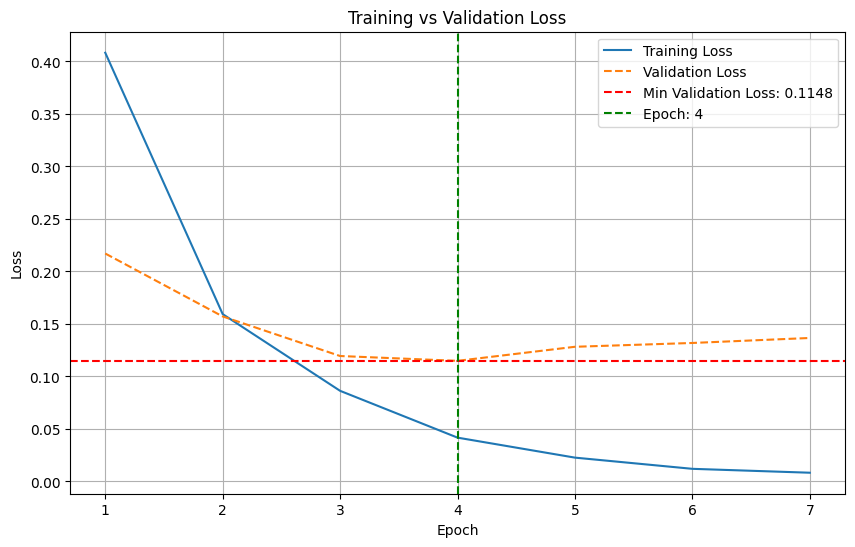

Macro-Averaged F1 Score: 0.5901

Micro-Averaged F1 Score: 0.7324

Weigthed-Averaged F1 Score: 0.7320

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.5000     0.6667     0.5714     6         

I-AND Gateway                       0.1667     1.0000     0.2857     2         

B-Activity                          0.8605     0.9487     0.9024     117       

I-Activity                          0.8000     0.5000     0.6154     8         

B-Activity Data                     0.7769     0.8545     0.8139     110       

I-Activity Data                     0.6260     0.7404     0.6784     104       

B-Actor                             0.8235     0.9515     0.8829     103       

I-Actor                             0.6949     0.8817     0.7773     93        

B-Condition Specification           0.5000     0.5000     0.5000     6         

I-Condition Specification           0.3750     0.5000     0.4286     6         

B-Furth

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 4.1036, Precision: 0.0000, Recall: 0.0018, F1: 0.0000
Step 50, Loss: 0.2798, Precision: 0.9235, Recall: 0.9233, F1: 0.9132
Average training loss: 0.5468

Macro-Averaged F1 Score: 0.1403

Micro-Averaged F1 Score: 0.3680

Weigthed-Averaged F1 Score: 0.3276

Epoch 2/7
Training...
Step 0, Loss: 0.2121, Precision: 0.9259, Recall: 0.9124, F1: 0.9086
Step 50, Loss: 0.1643, Precision: 0.9441, Recall: 0.9407, F1: 0.9397
Average training loss: 0.2104

Macro-Averaged F1 Score: 0.2883

Micro-Averaged F1 Score: 0.5452

Weigthed-Averaged F1 Score: 0.5395

Epoch 3/7
Training...
Step 0, Loss: 0.1816, Precision: 0.9434, Recall: 0.9382, F1: 0.9378
Step 50, Loss: 0.0599, Precision: 0.9405, Recall: 0.9474, F1: 0.9384
Average training loss: 0.1183

Macro-Averaged F1 Score: 0.3377

Micro-Averaged F1 Score: 0.5308

Weigthed-Averaged F1 Score: 0.5323

Epoch 4/7
Training...
Step 0, Loss: 0.2332, Precision: 0.9462, Recall: 0.9527, F1: 0.9456
Step 50, Loss: 0.0616, Precision: 

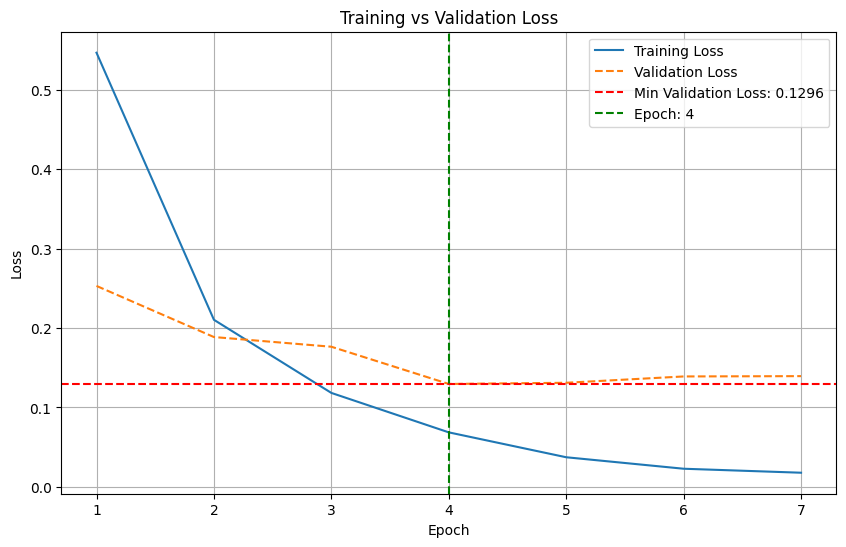

Macro-Averaged F1 Score: 0.5538

Micro-Averaged F1 Score: 0.7045

Weigthed-Averaged F1 Score: 0.7048

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     8         

I-AND Gateway                       0.0000     0.0000     0.0000     3         

B-Activity                          0.8239     0.8864     0.8540     132       

I-Activity                          0.7143     0.5000     0.5882     10        

B-Activity Data                     0.8205     0.7680     0.7934     125       

I-Activity Data                     0.6423     0.7182     0.6781     110       

B-Actor                             0.7624     0.7404     0.7512     104       

I-Actor                             0.6436     0.7738     0.7027     84        

B-Condition Specification           0.8571     0.7059     0.7742     17        

I-Condition Specification           0.5333     0.5000     0.5161     16        

B-Furth

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 3.3932, Precision: 0.4525, Recall: 0.0021, F1: 0.0011
Step 50, Loss: 0.1134, Precision: 0.9236, Recall: 0.9332, F1: 0.9226
Average training loss: 0.4856

Macro-Averaged F1 Score: 0.1821

Micro-Averaged F1 Score: 0.3621

Weigthed-Averaged F1 Score: 0.3579

Epoch 2/7
Training...
Step 0, Loss: 0.2118, Precision: 0.9261, Recall: 0.9334, F1: 0.9240
Step 50, Loss: 0.1526, Precision: 0.9528, Recall: 0.9561, F1: 0.9523
Average training loss: 0.1806

Macro-Averaged F1 Score: 0.3463

Micro-Averaged F1 Score: 0.6149

Weigthed-Averaged F1 Score: 0.6042

Epoch 3/7
Training...
Step 0, Loss: 0.2136, Precision: 0.9526, Recall: 0.9521, F1: 0.9490
Step 50, Loss: 0.0466, Precision: 0.9610, Recall: 0.9632, F1: 0.9606
Average training loss: 0.1116

Macro-Averaged F1 Score: 0.4705

Micro-Averaged F1 Score: 0.6869

Weigthed-Averaged F1 Score: 0.6835

Epoch 4/7
Training...
Step 0, Loss: 0.1124, Precision: 0.9616, Recall: 0.9619, F1: 0.9605
Step 50, Loss: 0.0135, Precision: 

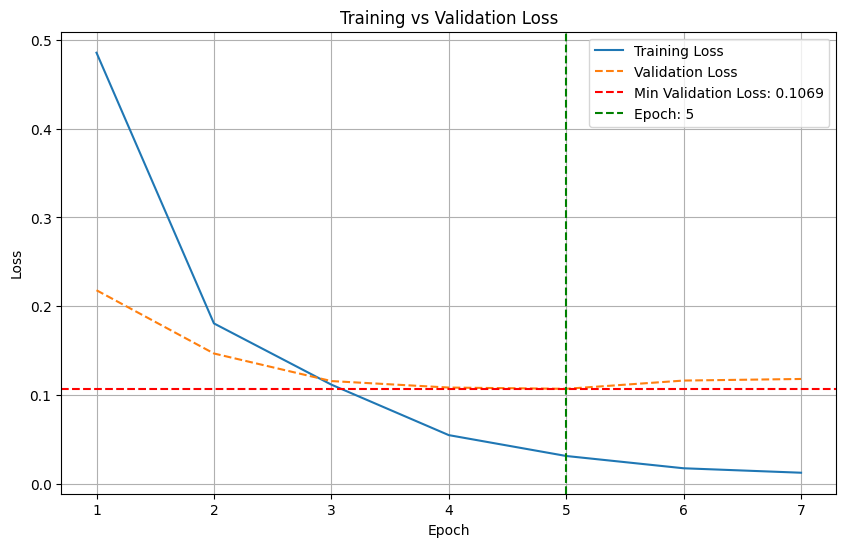

Macro-Averaged F1 Score: 0.5411

Micro-Averaged F1 Score: 0.7288

Weigthed-Averaged F1 Score: 0.7291

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       1.0000     0.1250     0.2222     8         

I-AND Gateway                       0.0000     0.0000     0.0000     5         

B-Activity                          0.8306     0.9196     0.8729     112       

I-Activity                          0.6667     0.6667     0.6667     9         

B-Activity Data                     0.8036     0.8571     0.8295     105       

I-Activity Data                     0.6423     0.8061     0.7149     98        

B-Actor                             0.8942     0.9029     0.8986     103       

I-Actor                             0.7900     0.8977     0.8404     88        

B-Condition Specification           0.8000     0.6000     0.6857     20        

I-Condition Specification           0.6111     0.5500     0.5789     20        

B-Furth

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.8754, Precision: 0.7868, Recall: 0.0087, F1: 0.0091
Step 50, Loss: 0.2307, Precision: 0.9034, Recall: 0.9291, F1: 0.9135
Average training loss: 0.4474

Macro-Averaged F1 Score: 0.2058

Micro-Averaged F1 Score: 0.4239

Weigthed-Averaged F1 Score: 0.4040

Epoch 2/7
Training...
Step 0, Loss: 0.2259, Precision: 0.9096, Recall: 0.9294, F1: 0.9172
Step 50, Loss: 0.1104, Precision: 0.9440, Recall: 0.9472, F1: 0.9450
Average training loss: 0.1424

Macro-Averaged F1 Score: 0.3767

Micro-Averaged F1 Score: 0.6101

Weigthed-Averaged F1 Score: 0.6119

Epoch 3/7
Training...
Step 0, Loss: 0.1314, Precision: 0.9461, Recall: 0.9466, F1: 0.9448
Step 50, Loss: 0.1071, Precision: 0.9494, Recall: 0.9529, F1: 0.9498
Average training loss: 0.0695

Macro-Averaged F1 Score: 0.4273

Micro-Averaged F1 Score: 0.6436

Weigthed-Averaged F1 Score: 0.6447

Epoch 4/7
Training...
Step 0, Loss: 0.1229, Precision: 0.9501, Recall: 0.9531, F1: 0.9507
Step 50, Loss: 0.0202, Precision: 

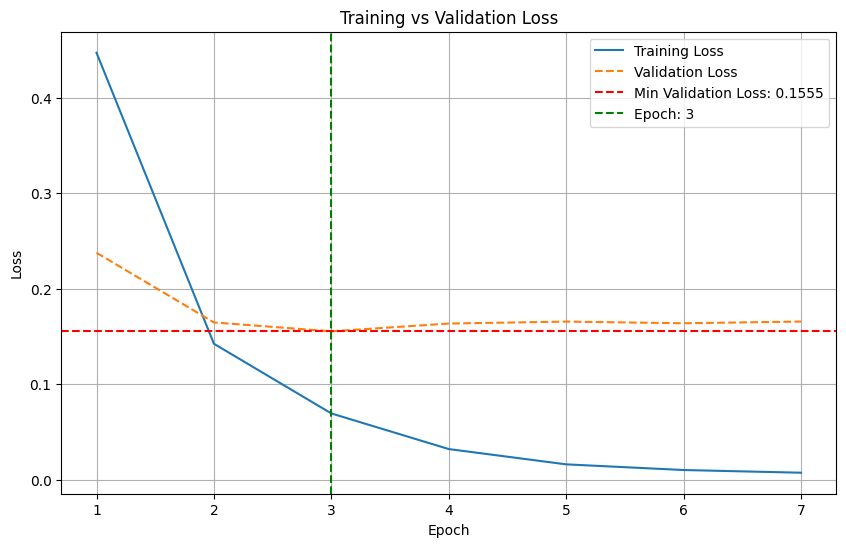

Macro-Averaged F1 Score: 0.5270

Micro-Averaged F1 Score: 0.6835

Weigthed-Averaged F1 Score: 0.6871

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     4         

I-AND Gateway                       0.0000     0.0000     0.0000     2         

B-Activity                          0.7794     0.8154     0.7970     130       

I-Activity                          1.0000     0.1818     0.3077     11        

B-Activity Data                     0.7705     0.8103     0.7899     116       

I-Activity Data                     0.5806     0.6857     0.6288     105       

B-Actor                             0.8611     0.8158     0.8378     114       

I-Actor                             0.7159     0.7683     0.7412     82        

B-Condition Specification           0.7407     0.6452     0.6897     31        

I-Condition Specification           0.4865     0.6207     0.5455     29        

B-Furth

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 3.4915, Precision: 0.0019, Recall: 0.0273, F1: 0.0021
Step 50, Loss: 0.1755, Precision: 0.8832, Recall: 0.9138, F1: 0.8875
Average training loss: 0.5158

Macro-Averaged F1 Score: 0.1102

Micro-Averaged F1 Score: 0.2156

Weigthed-Averaged F1 Score: 0.2003

Epoch 2/7
Training...
Step 0, Loss: 0.3349, Precision: 0.8847, Recall: 0.9150, F1: 0.8894
Step 50, Loss: 0.0984, Precision: 0.9523, Recall: 0.9532, F1: 0.9491
Average training loss: 0.1855

Macro-Averaged F1 Score: 0.3638

Micro-Averaged F1 Score: 0.6461

Weigthed-Averaged F1 Score: 0.6347

Epoch 3/7
Training...
Step 0, Loss: 0.1812, Precision: 0.9512, Recall: 0.9496, F1: 0.9468
Step 50, Loss: 0.0583, Precision: 0.9594, Recall: 0.9625, F1: 0.9605
Average training loss: 0.0971

Macro-Averaged F1 Score: 0.4687

Micro-Averaged F1 Score: 0.7195

Weigthed-Averaged F1 Score: 0.7150

Epoch 4/7
Training...
Step 0, Loss: 0.1391, Precision: 0.9603, Recall: 0.9608, F1: 0.9596
Step 50, Loss: 0.0388, Precision: 

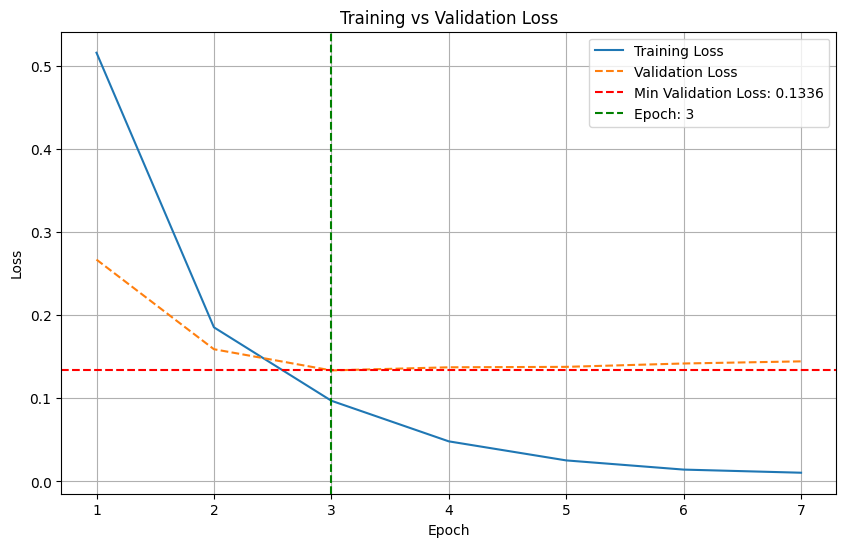

Macro-Averaged F1 Score: 0.5162

Micro-Averaged F1 Score: 0.7658

Weigthed-Averaged F1 Score: 0.7589

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     14        

I-AND Gateway                       0.0000     0.0000     0.0000     7         

B-Activity                          0.7899     0.8934     0.8385     122       

I-Activity                          0.2000     0.1667     0.1818     6         

B-Activity Data                     0.7538     0.8750     0.8099     112       

I-Activity Data                     0.6250     0.8247     0.7111     97        

B-Actor                             0.8710     0.9153     0.8926     118       

I-Actor                             0.8347     0.9099     0.8707     111       

B-Condition Specification           0.7692     0.8333     0.8000     24        

I-Condition Specification           0.5625     0.7500     0.6429     24        

B-Furth

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.5540, Precision: 0.7628, Recall: 0.1754, F1: 0.2725
Step 50, Loss: 0.1131, Precision: 0.9210, Recall: 0.9431, F1: 0.9299
Average training loss: 0.3854

Macro-Averaged F1 Score: 0.2551

Micro-Averaged F1 Score: 0.4934

Weigthed-Averaged F1 Score: 0.4787

Epoch 2/7
Training...
Step 0, Loss: 0.2460, Precision: 0.9196, Recall: 0.9415, F1: 0.9278
Step 50, Loss: 0.1125, Precision: 0.9511, Recall: 0.9595, F1: 0.9508
Average training loss: 0.1355

Macro-Averaged F1 Score: 0.3926

Micro-Averaged F1 Score: 0.6685

Weigthed-Averaged F1 Score: 0.6495

Epoch 3/7
Training...
Step 0, Loss: 0.0789, Precision: 0.9552, Recall: 0.9605, F1: 0.9529
Step 50, Loss: 0.0594, Precision: 0.9620, Recall: 0.9644, F1: 0.9594
Average training loss: 0.0720

Macro-Averaged F1 Score: 0.5669

Micro-Averaged F1 Score: 0.7483

Weigthed-Averaged F1 Score: 0.7367

Epoch 4/7
Training...
Step 0, Loss: 0.0937, Precision: 0.9624, Recall: 0.9647, F1: 0.9600
Step 50, Loss: 0.0383, Precision: 

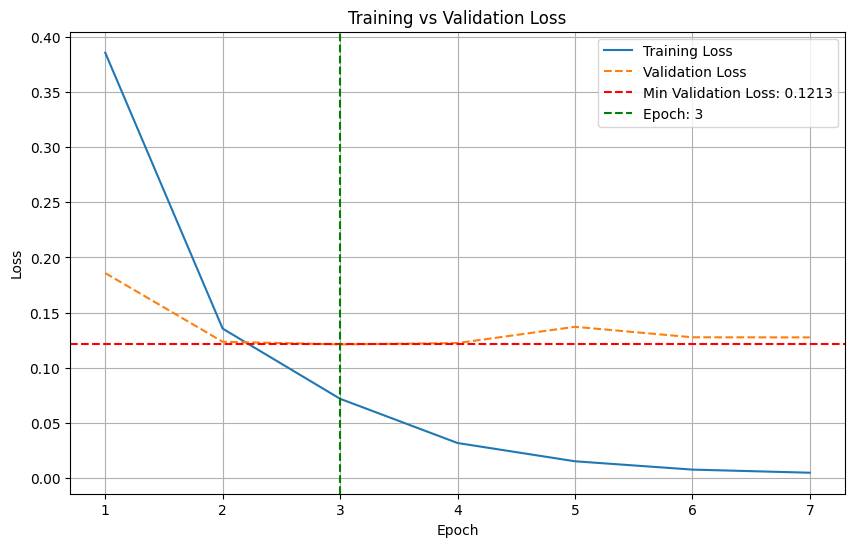

Macro-Averaged F1 Score: 0.6239

Micro-Averaged F1 Score: 0.7623

Weigthed-Averaged F1 Score: 0.7614

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.4000     0.3333     0.3636     6         

I-AND Gateway                       0.1667     0.5000     0.2500     2         

B-Activity                          0.8871     0.9402     0.9129     117       

I-Activity                          0.8571     0.7500     0.8000     8         

B-Activity Data                     0.8305     0.8909     0.8596     110       

I-Activity Data                     0.6557     0.7692     0.7080     104       

B-Actor                             0.8716     0.9223     0.8962     103       

I-Actor                             0.7429     0.8387     0.7879     93        

B-Condition Specification           1.0000     0.5000     0.6667     6         

I-Condition Specification           1.0000     0.5000     0.6667     6         

B-Furth

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.0651, Precision: 0.8109, Recall: 0.9004, F1: 0.8533
Step 50, Loss: 0.1117, Precision: 0.9278, Recall: 0.9435, F1: 0.9310
Average training loss: 0.3456

Macro-Averaged F1 Score: 0.2718

Micro-Averaged F1 Score: 0.5319

Weigthed-Averaged F1 Score: 0.5113

Epoch 2/7
Training...
Step 0, Loss: 0.2336, Precision: 0.9416, Recall: 0.9473, F1: 0.9372
Step 50, Loss: 0.1046, Precision: 0.9578, Recall: 0.9583, F1: 0.9566
Average training loss: 0.1272

Macro-Averaged F1 Score: 0.4228

Micro-Averaged F1 Score: 0.6693

Weigthed-Averaged F1 Score: 0.6639

Epoch 3/7
Training...
Step 0, Loss: 0.0919, Precision: 0.9595, Recall: 0.9573, F1: 0.9563
Step 50, Loss: 0.0694, Precision: 0.9627, Recall: 0.9641, F1: 0.9624
Average training loss: 0.0569

Macro-Averaged F1 Score: 0.5476

Micro-Averaged F1 Score: 0.7410

Weigthed-Averaged F1 Score: 0.7379

Epoch 4/7
Training...
Step 0, Loss: 0.0317, Precision: 0.9632, Recall: 0.9619, F1: 0.9611
Step 50, Loss: 0.0312, Precision: 

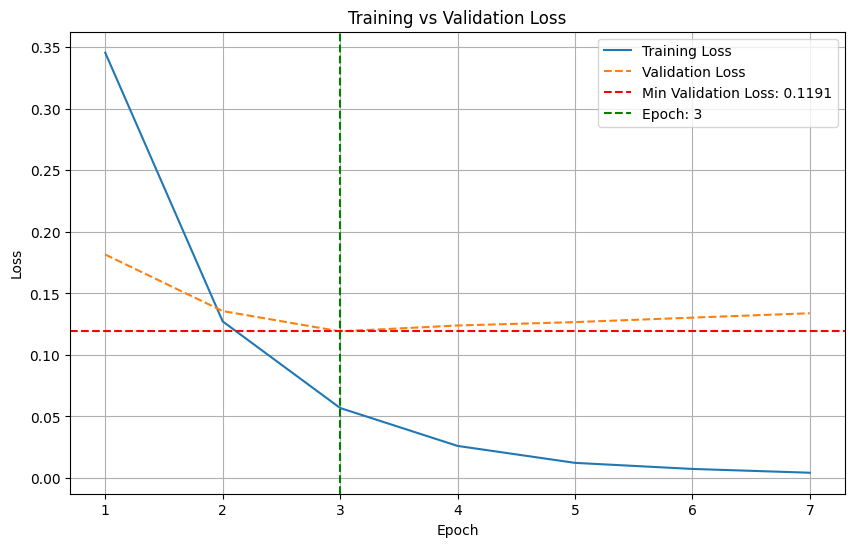

Macro-Averaged F1 Score: 0.6564

Micro-Averaged F1 Score: 0.7685

Weigthed-Averaged F1 Score: 0.7744

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.7500     0.3750     0.5000     8         

I-AND Gateway                       0.0000     0.0000     0.0000     3         

B-Activity                          0.8803     0.9470     0.9124     132       

I-Activity                          0.8182     0.9000     0.8571     10        

B-Activity Data                     0.7574     0.8240     0.7893     125       

I-Activity Data                     0.6308     0.7455     0.6833     110       

B-Actor                             0.7931     0.8846     0.8364     104       

I-Actor                             0.7527     0.8333     0.7910     84        

B-Condition Specification           0.9231     0.7059     0.8000     17        

I-Condition Specification           0.5556     0.6250     0.5882     16        

B-Furth

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 3.2043, Precision: 0.5235, Recall: 0.0277, F1: 0.0031
Step 50, Loss: 0.2128, Precision: 0.9443, Recall: 0.9432, F1: 0.9370
Average training loss: 0.4386

Macro-Averaged F1 Score: 0.2792

Micro-Averaged F1 Score: 0.5623

Weigthed-Averaged F1 Score: 0.5331

Epoch 2/7
Training...
Step 0, Loss: 0.1994, Precision: 0.9424, Recall: 0.9480, F1: 0.9395
Step 50, Loss: 0.1683, Precision: 0.9614, Recall: 0.9658, F1: 0.9622
Average training loss: 0.1441

Macro-Averaged F1 Score: 0.4413

Micro-Averaged F1 Score: 0.7002

Weigthed-Averaged F1 Score: 0.6891

Epoch 3/7
Training...
Step 0, Loss: 0.1740, Precision: 0.9632, Recall: 0.9629, F1: 0.9615
Step 50, Loss: 0.0342, Precision: 0.9686, Recall: 0.9721, F1: 0.9691
Average training loss: 0.0665

Macro-Averaged F1 Score: 0.5516

Micro-Averaged F1 Score: 0.7597

Weigthed-Averaged F1 Score: 0.7503

Epoch 4/7
Training...
Step 0, Loss: 0.1181, Precision: 0.9697, Recall: 0.9717, F1: 0.9696
Step 50, Loss: 0.0233, Precision: 

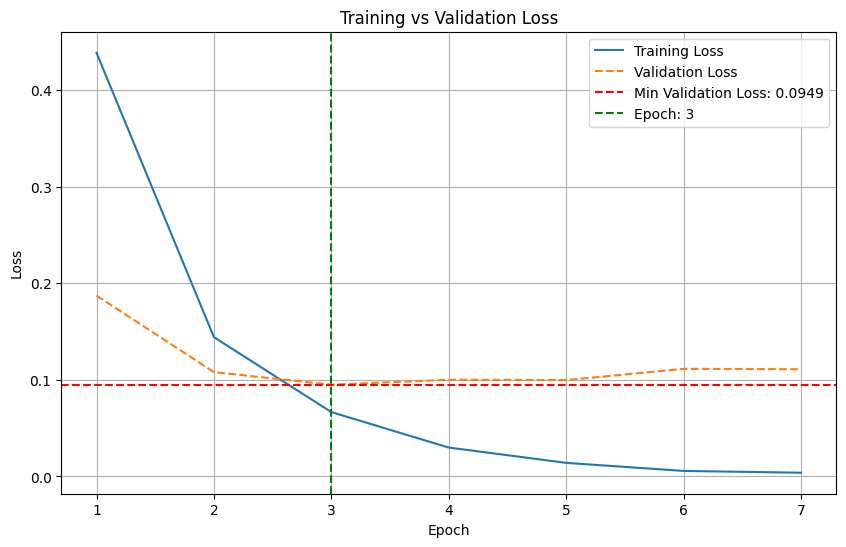

Macro-Averaged F1 Score: 0.6887

Micro-Averaged F1 Score: 0.7842

Weigthed-Averaged F1 Score: 0.7860

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.6667     0.2500     0.3636     8         

I-AND Gateway                       1.0000     0.4000     0.5714     5         

B-Activity                          0.8640     0.9643     0.9114     112       

I-Activity                          1.0000     0.8889     0.9412     9         

B-Activity Data                     0.8333     0.9048     0.8676     105       

I-Activity Data                     0.6723     0.8163     0.7373     98        

B-Actor                             0.8534     0.9612     0.9041     103       

I-Actor                             0.8125     0.8864     0.8478     88        

B-Condition Specification           0.7647     0.6500     0.7027     20        

I-Condition Specification           0.6000     0.6000     0.6000     20        

B-Furth

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.8529, Precision: 0.6843, Recall: 0.0702, F1: 0.1220
Step 50, Loss: 0.1716, Precision: 0.9281, Recall: 0.9306, F1: 0.9248
Average training loss: 0.3851

Macro-Averaged F1 Score: 0.2883

Micro-Averaged F1 Score: 0.5515

Weigthed-Averaged F1 Score: 0.5284

Epoch 2/7
Training...
Step 0, Loss: 0.1704, Precision: 0.9305, Recall: 0.9295, F1: 0.9258
Step 50, Loss: 0.1082, Precision: 0.9447, Recall: 0.9519, F1: 0.9448
Average training loss: 0.1290

Macro-Averaged F1 Score: 0.4318

Micro-Averaged F1 Score: 0.6229

Weigthed-Averaged F1 Score: 0.6152

Epoch 3/7
Training...
Step 0, Loss: 0.1203, Precision: 0.9481, Recall: 0.9530, F1: 0.9485
Step 50, Loss: 0.0467, Precision: 0.9467, Recall: 0.9496, F1: 0.9463
Average training loss: 0.0586

Macro-Averaged F1 Score: 0.4595

Micro-Averaged F1 Score: 0.6349

Weigthed-Averaged F1 Score: 0.6377

Epoch 4/7
Training...
Step 0, Loss: 0.0990, Precision: 0.9495, Recall: 0.9469, F1: 0.9468
Step 50, Loss: 0.0193, Precision: 

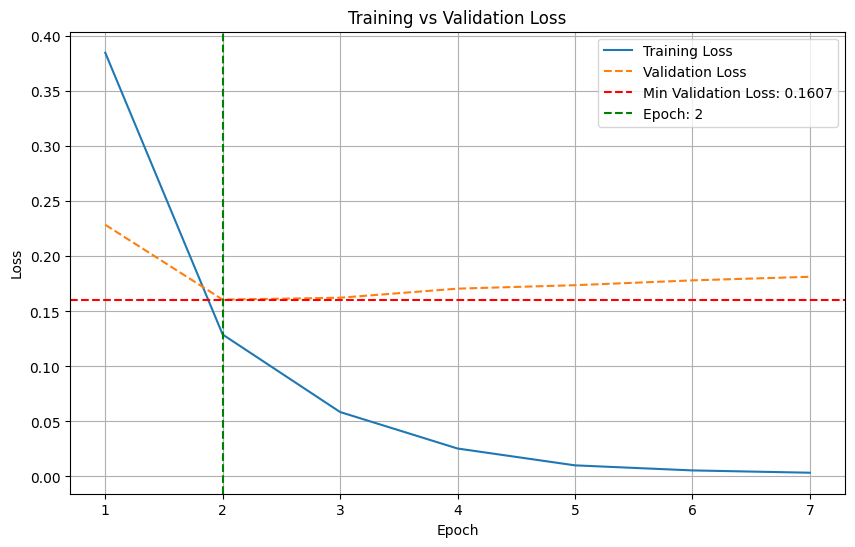

Macro-Averaged F1 Score: 0.5323

Micro-Averaged F1 Score: 0.6937

Weigthed-Averaged F1 Score: 0.6974

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     4         

I-AND Gateway                       0.0000     0.0000     0.0000     2         

B-Activity                          0.8074     0.8385     0.8226     130       

I-Activity                          0.6667     0.1818     0.2857     11        

B-Activity Data                     0.7769     0.8103     0.7932     116       

I-Activity Data                     0.5462     0.6762     0.6043     105       

B-Actor                             0.8198     0.7982     0.8089     114       

I-Actor                             0.6947     0.8049     0.7458     82        

B-Condition Specification           0.7931     0.7419     0.7667     31        

I-Condition Specification           0.4872     0.6552     0.5588     29        

B-Furth

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.8788, Precision: 0.5898, Recall: 0.0105, F1: 0.0145
Step 50, Loss: 0.2306, Precision: 0.8402, Recall: 0.8933, F1: 0.8500
Average training loss: 0.4643

Macro-Averaged F1 Score: 0.0140

Micro-Averaged F1 Score: 0.0371

Weigthed-Averaged F1 Score: 0.0326

Epoch 2/7
Training...
Step 0, Loss: 0.4266, Precision: 0.8551, Recall: 0.8998, F1: 0.8663
Step 50, Loss: 0.1499, Precision: 0.9268, Recall: 0.9437, F1: 0.9316
Average training loss: 0.2186

Macro-Averaged F1 Score: 0.2745

Micro-Averaged F1 Score: 0.5700

Weigthed-Averaged F1 Score: 0.5355

Epoch 3/7
Training...
Step 0, Loss: 0.1692, Precision: 0.9254, Recall: 0.9435, F1: 0.9310
Step 50, Loss: 0.0982, Precision: 0.9562, Recall: 0.9622, F1: 0.9587
Average training loss: 0.1161

Macro-Averaged F1 Score: 0.4667

Micro-Averaged F1 Score: 0.7146

Weigthed-Averaged F1 Score: 0.7085

Epoch 4/7
Training...
Step 0, Loss: 0.1419, Precision: 0.9594, Recall: 0.9615, F1: 0.9594
Step 50, Loss: 0.0738, Precision: 

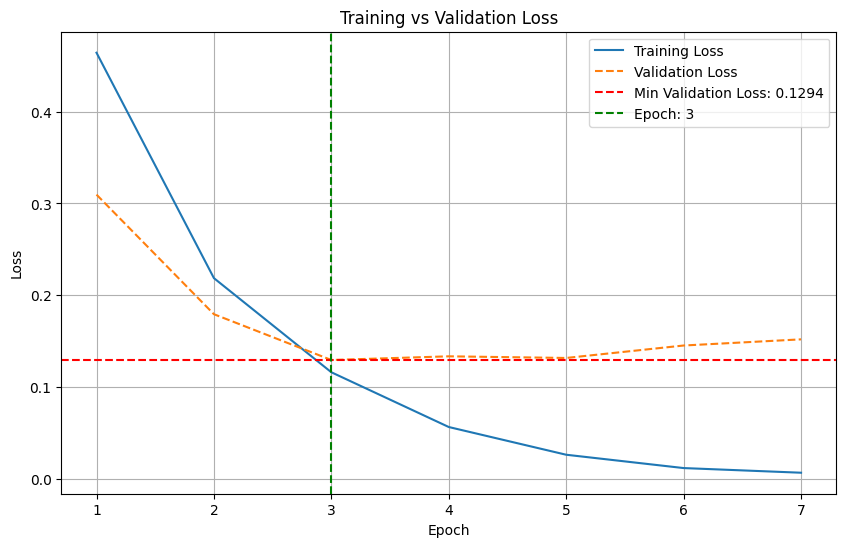

Macro-Averaged F1 Score: 0.5119

Micro-Averaged F1 Score: 0.7462

Weigthed-Averaged F1 Score: 0.7436

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.2500     0.0714     0.1111     14        

I-AND Gateway                       0.0000     0.0000     0.0000     7         

B-Activity                          0.7651     0.9344     0.8413     122       

I-Activity                          0.2857     0.3333     0.3077     6         

B-Activity Data                     0.7556     0.9107     0.8259     112       

I-Activity Data                     0.5652     0.8041     0.6638     97        

B-Actor                             0.8504     0.9153     0.8816     118       

I-Actor                             0.8430     0.9189     0.8793     111       

B-Condition Specification           0.7083     0.7083     0.7083     24        

I-Condition Specification           0.4324     0.6667     0.5246     24        

B-Furth

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 3.1343, Precision: 0.6489, Recall: 0.1118, F1: 0.1894
Step 50, Loss: 0.1543, Precision: 0.9246, Recall: 0.9449, F1: 0.9326
Average training loss: 0.4034

Macro-Averaged F1 Score: 0.2827

Micro-Averaged F1 Score: 0.5460

Weigthed-Averaged F1 Score: 0.5314

Epoch 2/7
Training...
Step 0, Loss: 0.1930, Precision: 0.9141, Recall: 0.9352, F1: 0.9175
Step 50, Loss: 0.1516, Precision: 0.9616, Recall: 0.9622, F1: 0.9603
Average training loss: 0.1251

Macro-Averaged F1 Score: 0.4596

Micro-Averaged F1 Score: 0.6750

Weigthed-Averaged F1 Score: 0.6798

Epoch 3/7
Training...
Step 0, Loss: 0.2145, Precision: 0.9614, Recall: 0.9631, F1: 0.9613
Step 50, Loss: 0.0073, Precision: 0.9662, Recall: 0.9678, F1: 0.9651
Average training loss: 0.0549

Macro-Averaged F1 Score: 0.5907

Micro-Averaged F1 Score: 0.7503

Weigthed-Averaged F1 Score: 0.7478

Epoch 4/7
Training...
Step 0, Loss: 0.0480, Precision: 0.9660, Recall: 0.9675, F1: 0.9647
Step 50, Loss: 0.0380, Precision: 

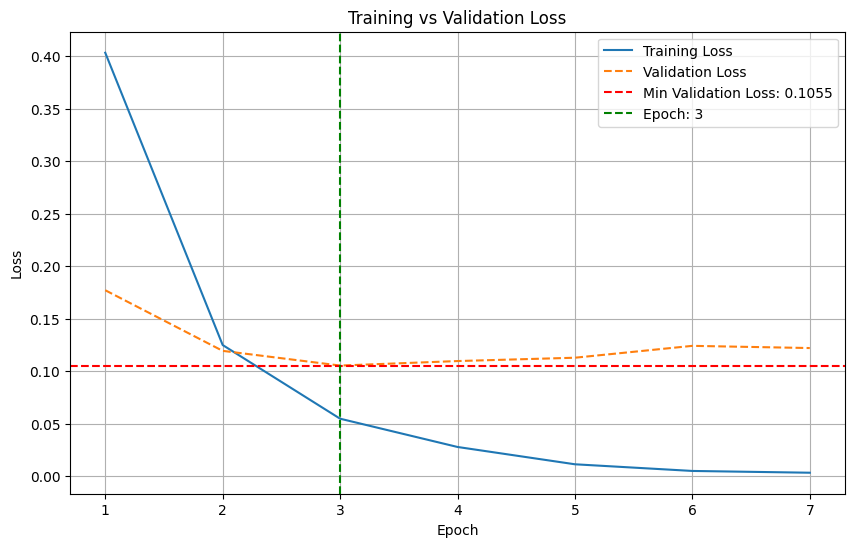

Macro-Averaged F1 Score: 0.6393

Micro-Averaged F1 Score: 0.7825

Weigthed-Averaged F1 Score: 0.7831

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.5000     0.3333     0.4000     6         

I-AND Gateway                       0.1111     0.5000     0.1818     2         

B-Activity                          0.8561     0.9658     0.9076     117       

I-Activity                          0.8571     0.7500     0.8000     8         

B-Activity Data                     0.8049     0.9000     0.8498     110       

I-Activity Data                     0.6299     0.7692     0.6926     104       

B-Actor                             0.9091     0.9709     0.9390     103       

I-Actor                             0.8058     0.8925     0.8469     93        

B-Condition Specification           1.0000     0.6667     0.8000     6         

I-Condition Specification           0.6000     0.5000     0.5455     6         

B-Furth

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 3.0932, Precision: 0.6333, Recall: 0.0166, F1: 0.0146
Step 50, Loss: 0.1496, Precision: 0.9100, Recall: 0.9305, F1: 0.9141
Average training loss: 0.4030

Macro-Averaged F1 Score: 0.1683

Micro-Averaged F1 Score: 0.3339

Weigthed-Averaged F1 Score: 0.3335

Epoch 2/7
Training...
Step 0, Loss: 0.1669, Precision: 0.9086, Recall: 0.9266, F1: 0.9069
Step 50, Loss: 0.0799, Precision: 0.9390, Recall: 0.9490, F1: 0.9395
Average training loss: 0.1411

Macro-Averaged F1 Score: 0.3614

Micro-Averaged F1 Score: 0.5454

Weigthed-Averaged F1 Score: 0.5384

Epoch 3/7
Training...
Step 0, Loss: 0.1405, Precision: 0.9485, Recall: 0.9573, F1: 0.9510
Step 50, Loss: 0.0592, Precision: 0.9607, Recall: 0.9612, F1: 0.9592
Average training loss: 0.0747

Macro-Averaged F1 Score: 0.5068

Micro-Averaged F1 Score: 0.6882

Weigthed-Averaged F1 Score: 0.6846

Epoch 4/7
Training...
Step 0, Loss: 0.0526, Precision: 0.9593, Recall: 0.9607, F1: 0.9589
Step 50, Loss: 0.0345, Precision: 

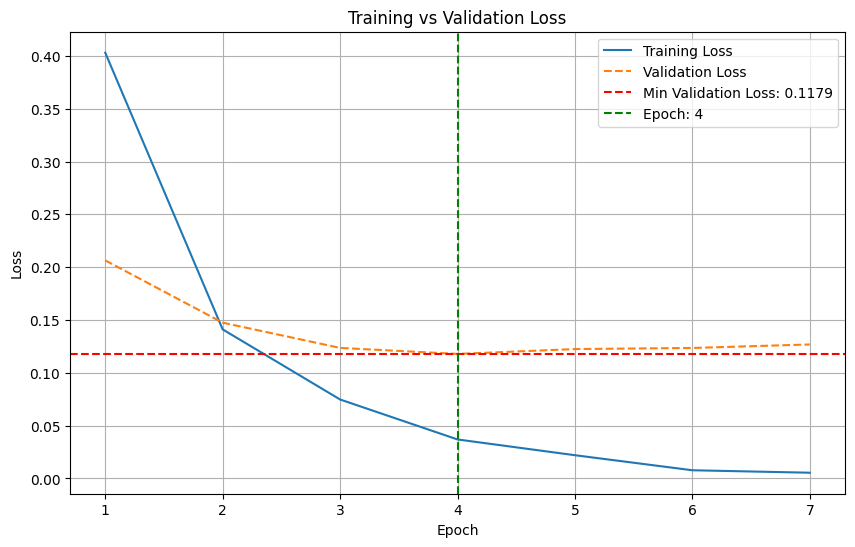

Macro-Averaged F1 Score: 0.5465

Micro-Averaged F1 Score: 0.7323

Weigthed-Averaged F1 Score: 0.7310

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     8         

I-AND Gateway                       0.0000     0.0000     0.0000     3         

B-Activity                          0.8219     0.9091     0.8633     132       

I-Activity                          0.7500     0.9000     0.8182     10        

B-Activity Data                     0.7863     0.8240     0.8047     125       

I-Activity Data                     0.6328     0.7364     0.6807     110       

B-Actor                             0.7586     0.8462     0.8000     104       

I-Actor                             0.6887     0.8690     0.7684     84        

B-Condition Specification           0.5556     0.5882     0.5714     17        

I-Condition Specification           0.4211     0.5000     0.4571     16        

B-Furth

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.6824, Precision: 0.8190, Recall: 0.8912, F1: 0.8516
Step 50, Loss: 0.2122, Precision: 0.9123, Recall: 0.9357, F1: 0.9232
Average training loss: 0.4162

Macro-Averaged F1 Score: 0.1909

Micro-Averaged F1 Score: 0.3868

Weigthed-Averaged F1 Score: 0.3758

Epoch 2/7
Training...
Step 0, Loss: 0.2991, Precision: 0.9200, Recall: 0.9389, F1: 0.9287
Step 50, Loss: 0.1950, Precision: 0.9579, Recall: 0.9576, F1: 0.9565
Average training loss: 0.1650

Macro-Averaged F1 Score: 0.4259

Micro-Averaged F1 Score: 0.6469

Weigthed-Averaged F1 Score: 0.6524

Epoch 3/7
Training...
Step 0, Loss: 0.1069, Precision: 0.9564, Recall: 0.9604, F1: 0.9570
Step 50, Loss: 0.1428, Precision: 0.9682, Recall: 0.9602, F1: 0.9624
Average training loss: 0.0820

Macro-Averaged F1 Score: 0.5369

Micro-Averaged F1 Score: 0.7132

Weigthed-Averaged F1 Score: 0.7229

Epoch 4/7
Training...
Step 0, Loss: 0.1240, Precision: 0.9677, Recall: 0.9571, F1: 0.9601
Step 50, Loss: 0.0224, Precision: 

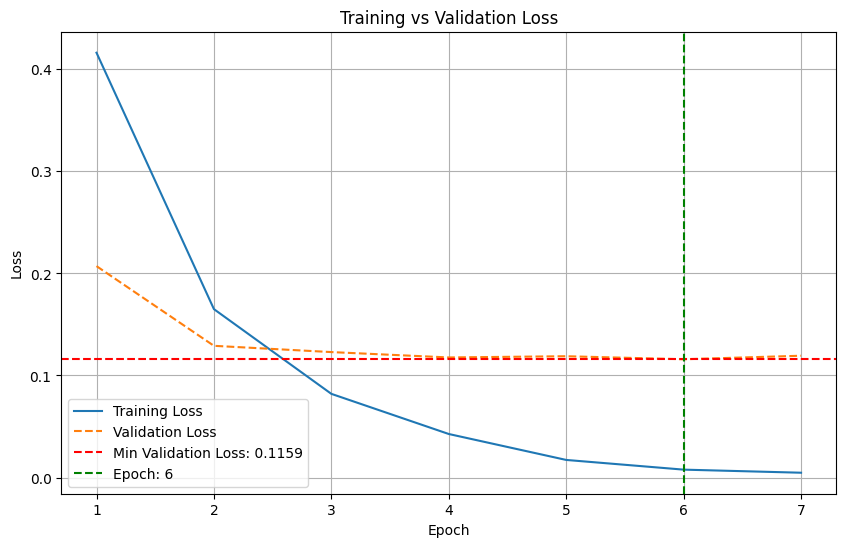

Macro-Averaged F1 Score: 0.6412

Micro-Averaged F1 Score: 0.7500

Weigthed-Averaged F1 Score: 0.7536

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       1.0000     0.3750     0.5455     8         

I-AND Gateway                       1.0000     0.4000     0.5714     5         

B-Activity                          0.8387     0.9286     0.8814     112       

I-Activity                          0.8889     0.8889     0.8889     9         

B-Activity Data                     0.8053     0.8667     0.8349     105       

I-Activity Data                     0.6179     0.7755     0.6878     98        

B-Actor                             0.8981     0.9417     0.9194     103       

I-Actor                             0.8041     0.8864     0.8432     88        

B-Condition Specification           0.7857     0.5500     0.6471     20        

I-Condition Specification           0.5500     0.5500     0.5500     20        

B-Furth

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 3.1433, Precision: 0.3497, Recall: 0.0625, F1: 0.0943
Step 50, Loss: 0.2545, Precision: 0.8793, Recall: 0.9090, F1: 0.8792
Average training loss: 0.4715

Macro-Averaged F1 Score: 0.1151

Micro-Averaged F1 Score: 0.2517

Weigthed-Averaged F1 Score: 0.2235

Epoch 2/7
Training...
Step 0, Loss: 0.2776, Precision: 0.8840, Recall: 0.9127, F1: 0.8854
Step 50, Loss: 0.1458, Precision: 0.9247, Recall: 0.9378, F1: 0.9259
Average training loss: 0.1677

Macro-Averaged F1 Score: 0.3065

Micro-Averaged F1 Score: 0.4992

Weigthed-Averaged F1 Score: 0.4947

Epoch 3/7
Training...
Step 0, Loss: 0.2129, Precision: 0.9409, Recall: 0.9479, F1: 0.9407
Step 50, Loss: 0.0629, Precision: 0.9618, Recall: 0.9428, F1: 0.9507
Average training loss: 0.0819

Macro-Averaged F1 Score: 0.4557

Micro-Averaged F1 Score: 0.6368

Weigthed-Averaged F1 Score: 0.6701

Epoch 4/7
Training...
Step 0, Loss: 0.1005, Precision: 0.9613, Recall: 0.9430, F1: 0.9507
Step 50, Loss: 0.0238, Precision: 

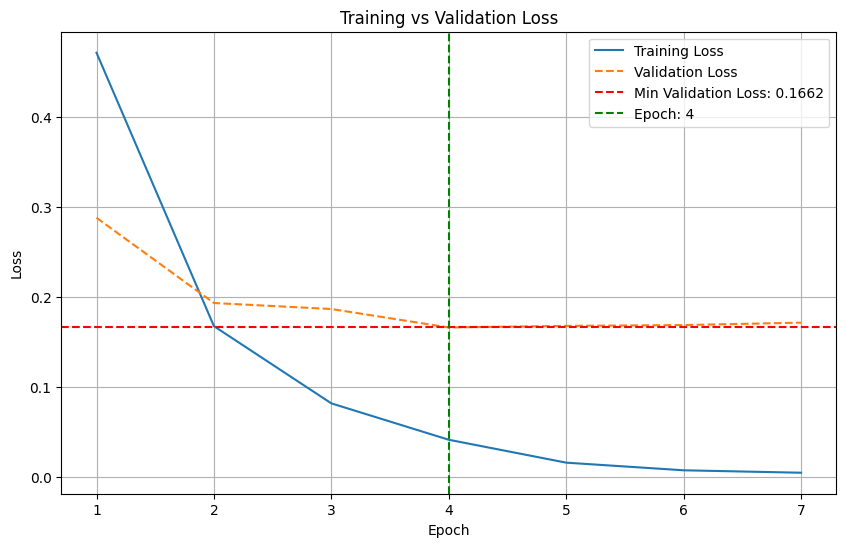

Macro-Averaged F1 Score: 0.5546

Micro-Averaged F1 Score: 0.6897

Weigthed-Averaged F1 Score: 0.6944

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.2500     0.2500     0.2500     4         

I-AND Gateway                       0.0000     0.0000     0.0000     2         

B-Activity                          0.7762     0.8538     0.8132     130       

I-Activity                          0.6667     0.1818     0.2857     11        

B-Activity Data                     0.7823     0.8362     0.8083     116       

I-Activity Data                     0.5781     0.7048     0.6352     105       

B-Actor                             0.8390     0.8684     0.8534     114       

I-Actor                             0.7204     0.8171     0.7657     82        

B-Condition Specification           0.7037     0.6129     0.6552     31        

I-Condition Specification           0.4419     0.6552     0.5278     29        

B-Furth

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.5065, Precision: 0.8385, Recall: 0.4367, F1: 0.5678
Step 50, Loss: 0.1696, Precision: 0.9334, Recall: 0.9445, F1: 0.9345
Average training loss: 0.3710

Macro-Averaged F1 Score: 0.2656

Micro-Averaged F1 Score: 0.5187

Weigthed-Averaged F1 Score: 0.4999

Epoch 2/7
Training...
Step 0, Loss: 0.1995, Precision: 0.9436, Recall: 0.9459, F1: 0.9397
Step 50, Loss: 0.0913, Precision: 0.9601, Recall: 0.9647, F1: 0.9618
Average training loss: 0.1121

Macro-Averaged F1 Score: 0.4930

Micro-Averaged F1 Score: 0.7487

Weigthed-Averaged F1 Score: 0.7382

Epoch 3/7
Training...
Step 0, Loss: 0.0806, Precision: 0.9607, Recall: 0.9647, F1: 0.9620
Step 50, Loss: 0.0374, Precision: 0.9693, Recall: 0.9653, F1: 0.9655
Average training loss: 0.0483

Macro-Averaged F1 Score: 0.5385

Micro-Averaged F1 Score: 0.7651

Weigthed-Averaged F1 Score: 0.7653

Epoch 4/7
Training...
Step 0, Loss: 0.0567, Precision: 0.9700, Recall: 0.9658, F1: 0.9659
Step 50, Loss: 0.0469, Precision: 

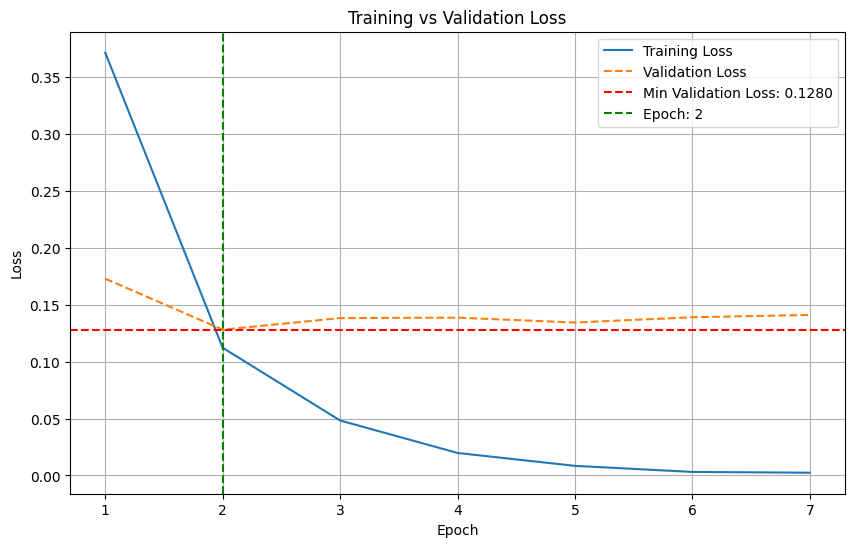

Macro-Averaged F1 Score: 0.6164

Micro-Averaged F1 Score: 0.7998

Weigthed-Averaged F1 Score: 0.7985

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.6667     0.2857     0.4000     14        

I-AND Gateway                       1.0000     0.1429     0.2500     7         

B-Activity                          0.8286     0.9508     0.8855     122       

I-Activity                          0.7500     0.5000     0.6000     6         

B-Activity Data                     0.7907     0.9107     0.8465     112       

I-Activity Data                     0.6641     0.8763     0.7556     97        

B-Actor                             0.8952     0.9407     0.9174     118       

I-Actor                             0.8226     0.9189     0.8681     111       

B-Condition Specification           0.7143     0.8333     0.7692     24        

I-Condition Specification           0.4857     0.7083     0.5763     24        

B-Furth

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 3.9736, Precision: 0.8717, Recall: 0.0070, F1: 0.0055
Step 50, Loss: 0.2774, Precision: 0.9242, Recall: 0.9431, F1: 0.9324
Average training loss: 0.4897

Macro-Averaged F1 Score: 0.2413

Micro-Averaged F1 Score: 0.5095

Weigthed-Averaged F1 Score: 0.4862

Epoch 2/7
Training...
Step 0, Loss: 0.2275, Precision: 0.9283, Recall: 0.9423, F1: 0.9338
Step 50, Loss: 0.0926, Precision: 0.9513, Recall: 0.9563, F1: 0.9487
Average training loss: 0.1532

Macro-Averaged F1 Score: 0.3958

Micro-Averaged F1 Score: 0.6670

Weigthed-Averaged F1 Score: 0.6430

Epoch 3/7
Training...
Step 0, Loss: 0.1615, Precision: 0.9523, Recall: 0.9546, F1: 0.9474
Step 50, Loss: 0.2641, Precision: 0.9587, Recall: 0.9619, F1: 0.9581
Average training loss: 0.0763

Macro-Averaged F1 Score: 0.3982

Micro-Averaged F1 Score: 0.6893

Weigthed-Averaged F1 Score: 0.6854

Epoch 4/7
Training...
Step 0, Loss: 0.2136, Precision: 0.9624, Recall: 0.9607, F1: 0.9601
Step 50, Loss: 0.1066, Precision: 

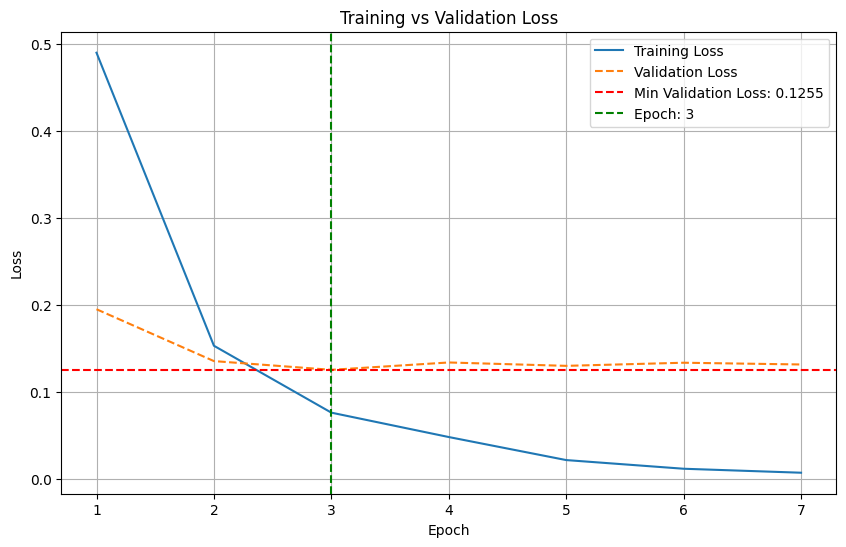

Macro-Averaged F1 Score: 0.6080

Micro-Averaged F1 Score: 0.7480

Weigthed-Averaged F1 Score: 0.7504

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.6667     0.3333     0.4444     6         

I-AND Gateway                       0.0714     0.5000     0.1250     2         

B-Activity                          0.8640     0.9231     0.8926     117       

I-Activity                          1.0000     0.6250     0.7692     8         

B-Activity Data                     0.8319     0.9000     0.8646     110       

I-Activity Data                     0.6720     0.8077     0.7336     104       

B-Actor                             0.8611     0.9029     0.8815     103       

I-Actor                             0.7551     0.7957     0.7749     93        

B-Condition Specification           0.8333     0.8333     0.8333     6         

I-Condition Specification           0.3636     0.6667     0.4706     6         

B-Furth

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.7786, Precision: 0.8112, Recall: 0.8833, F1: 0.8457
Step 50, Loss: 0.1790, Precision: 0.9252, Recall: 0.9419, F1: 0.9299
Average training loss: 0.3719

Macro-Averaged F1 Score: 0.2685

Micro-Averaged F1 Score: 0.4888

Weigthed-Averaged F1 Score: 0.4756

Epoch 2/7
Training...
Step 0, Loss: 0.3176, Precision: 0.9364, Recall: 0.9426, F1: 0.9377
Step 50, Loss: 0.1131, Precision: 0.9467, Recall: 0.9538, F1: 0.9464
Average training loss: 0.1758

Macro-Averaged F1 Score: 0.3604

Micro-Averaged F1 Score: 0.5932

Weigthed-Averaged F1 Score: 0.5849

Epoch 3/7
Training...
Step 0, Loss: 0.1831, Precision: 0.9525, Recall: 0.9573, F1: 0.9520
Step 50, Loss: 0.0866, Precision: 0.9609, Recall: 0.9619, F1: 0.9610
Average training loss: 0.0942

Macro-Averaged F1 Score: 0.5253

Micro-Averaged F1 Score: 0.6923

Weigthed-Averaged F1 Score: 0.7005

Epoch 4/7
Training...
Step 0, Loss: 0.1119, Precision: 0.9623, Recall: 0.9618, F1: 0.9618
Step 50, Loss: 0.0546, Precision: 

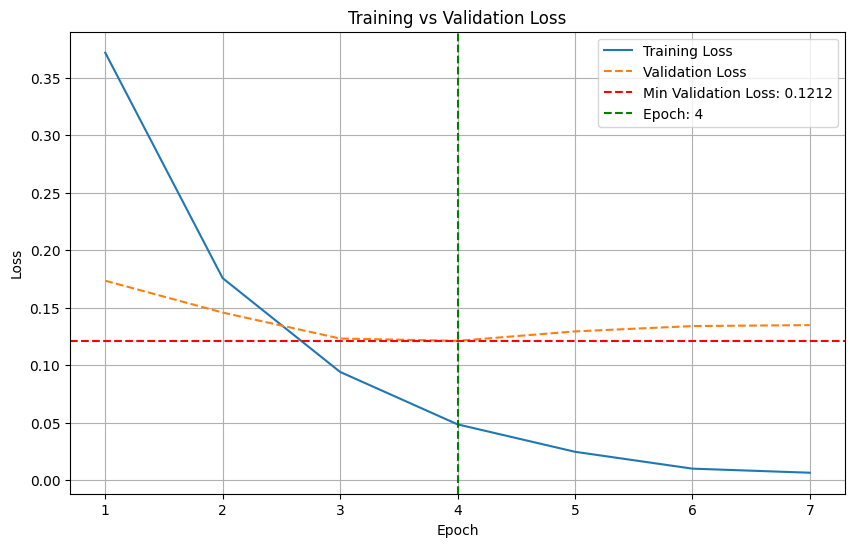

Macro-Averaged F1 Score: 0.6084

Micro-Averaged F1 Score: 0.7422

Weigthed-Averaged F1 Score: 0.7457

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.6000     0.3750     0.4615     8         

I-AND Gateway                       0.0000     0.0000     0.0000     3         

B-Activity                          0.8633     0.9091     0.8856     132       

I-Activity                          0.7500     0.9000     0.8182     10        

B-Activity Data                     0.8049     0.7920     0.7984     125       

I-Activity Data                     0.6303     0.6818     0.6550     110       

B-Actor                             0.8053     0.8750     0.8387     104       

I-Actor                             0.7500     0.8214     0.7841     84        

B-Condition Specification           0.6667     0.5882     0.6250     17        

I-Condition Specification           0.7692     0.6250     0.6897     16        

B-Furth

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.3011, Precision: 0.8152, Recall: 0.9026, F1: 0.8567
Step 50, Loss: 0.1577, Precision: 0.9524, Recall: 0.9493, F1: 0.9482
Average training loss: 0.3106

Macro-Averaged F1 Score: 0.3354

Micro-Averaged F1 Score: 0.6318

Weigthed-Averaged F1 Score: 0.6152

Epoch 2/7
Training...
Step 0, Loss: 0.1189, Precision: 0.9517, Recall: 0.9488, F1: 0.9471
Step 50, Loss: 0.1290, Precision: 0.9692, Recall: 0.9707, F1: 0.9688
Average training loss: 0.1186

Macro-Averaged F1 Score: 0.5609

Micro-Averaged F1 Score: 0.7385

Weigthed-Averaged F1 Score: 0.7375

Epoch 3/7
Training...
Step 0, Loss: 0.1481, Precision: 0.9698, Recall: 0.9696, F1: 0.9685
Step 50, Loss: 0.0079, Precision: 0.9748, Recall: 0.9753, F1: 0.9744
Average training loss: 0.0598

Macro-Averaged F1 Score: 0.6294

Micro-Averaged F1 Score: 0.7763

Weigthed-Averaged F1 Score: 0.7783

Epoch 4/7
Training...
Step 0, Loss: 0.0544, Precision: 0.9749, Recall: 0.9756, F1: 0.9746
Step 50, Loss: 0.0169, Precision: 

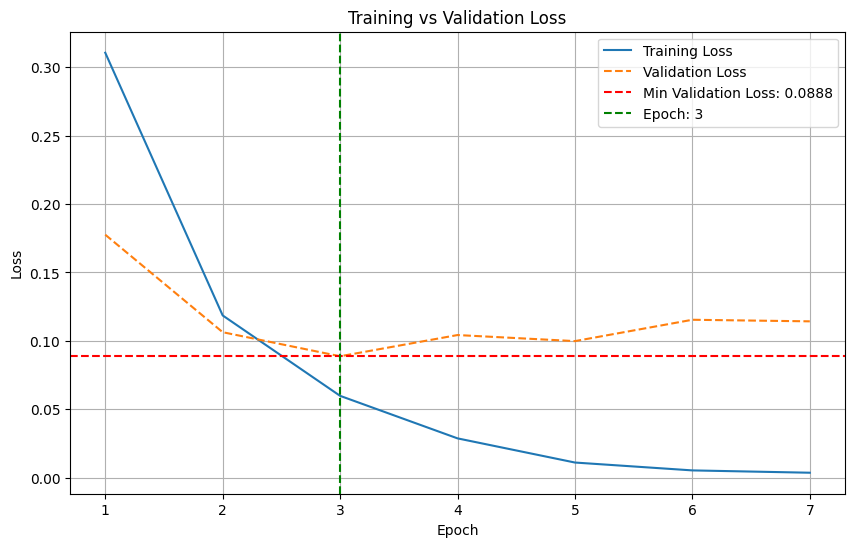

Macro-Averaged F1 Score: 0.6856

Micro-Averaged F1 Score: 0.7855

Weigthed-Averaged F1 Score: 0.7871

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       1.0000     0.5000     0.6667     8         

I-AND Gateway                       0.3333     0.2000     0.2500     5         

B-Activity                          0.8525     0.9286     0.8889     112       

I-Activity                          0.8750     0.7778     0.8235     9         

B-Activity Data                     0.8000     0.8762     0.8364     105       

I-Activity Data                     0.6757     0.7653     0.7177     98        

B-Actor                             0.9057     0.9320     0.9187     103       

I-Actor                             0.8438     0.9205     0.8804     88        

B-Condition Specification           0.8333     0.7500     0.7895     20        

I-Condition Specification           0.6000     0.6000     0.6000     20        

B-Furth

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.5339, Precision: 0.7786, Recall: 0.8808, F1: 0.8265
Step 50, Loss: 0.1144, Precision: 0.9273, Recall: 0.9418, F1: 0.9335
Average training loss: 0.3233

Macro-Averaged F1 Score: 0.3073

Micro-Averaged F1 Score: 0.5440

Weigthed-Averaged F1 Score: 0.5346

Epoch 2/7
Training...
Step 0, Loss: 0.2735, Precision: 0.9301, Recall: 0.9429, F1: 0.9361
Step 50, Loss: 0.1369, Precision: 0.9470, Recall: 0.9484, F1: 0.9460
Average training loss: 0.1196

Macro-Averaged F1 Score: 0.4155

Micro-Averaged F1 Score: 0.6358

Weigthed-Averaged F1 Score: 0.6401

Epoch 3/7
Training...
Step 0, Loss: 0.1297, Precision: 0.9485, Recall: 0.9483, F1: 0.9471
Step 50, Loss: 0.0371, Precision: 0.9518, Recall: 0.9548, F1: 0.9522
Average training loss: 0.0697

Macro-Averaged F1 Score: 0.5409

Micro-Averaged F1 Score: 0.6811

Weigthed-Averaged F1 Score: 0.6818

Epoch 4/7
Training...
Step 0, Loss: 0.1084, Precision: 0.9532, Recall: 0.9544, F1: 0.9532
Step 50, Loss: 0.0405, Precision: 

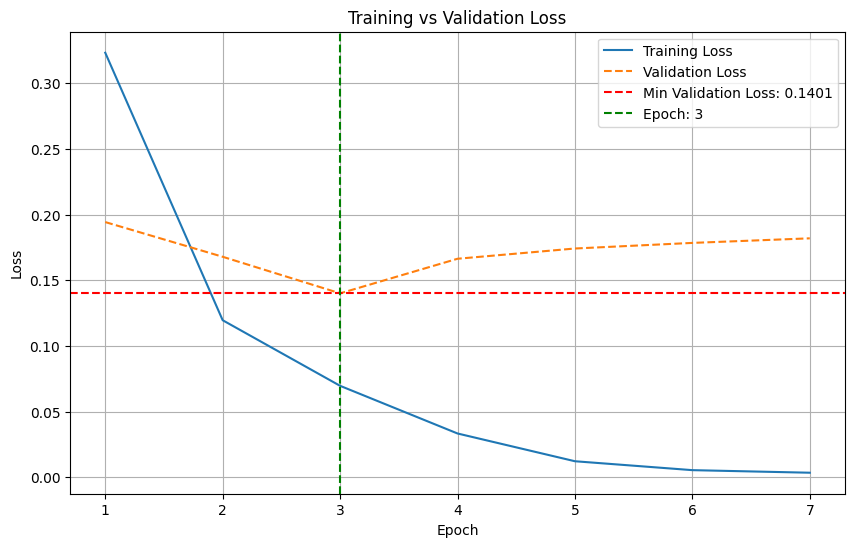

Macro-Averaged F1 Score: 0.6018

Micro-Averaged F1 Score: 0.7065

Weigthed-Averaged F1 Score: 0.7101

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.6667     0.5000     0.5714     4         

I-AND Gateway                       0.0000     0.0000     0.0000     2         

B-Activity                          0.8492     0.8231     0.8359     130       

I-Activity                          0.8000     0.3636     0.5000     11        

B-Activity Data                     0.8364     0.7931     0.8142     116       

I-Activity Data                     0.6018     0.6476     0.6239     105       

B-Actor                             0.8393     0.8246     0.8319     114       

I-Actor                             0.7222     0.7927     0.7558     82        

B-Condition Specification           0.7857     0.7097     0.7458     31        

I-Condition Specification           0.5806     0.6207     0.6000     29        

B-Furth

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 3.5605, Precision: 0.8183, Recall: 0.1008, F1: 0.1767
Step 50, Loss: 0.1400, Precision: 0.9391, Recall: 0.9487, F1: 0.9413
Average training loss: 0.4483

Macro-Averaged F1 Score: 0.3310

Micro-Averaged F1 Score: 0.5937

Weigthed-Averaged F1 Score: 0.5757

Epoch 2/7
Training...
Step 0, Loss: 0.2042, Precision: 0.9384, Recall: 0.9479, F1: 0.9404
Step 50, Loss: 0.1001, Precision: 0.9534, Recall: 0.9621, F1: 0.9572
Average training loss: 0.1193

Macro-Averaged F1 Score: 0.4865

Micro-Averaged F1 Score: 0.7174

Weigthed-Averaged F1 Score: 0.7067

Epoch 3/7
Training...
Step 0, Loss: 0.2201, Precision: 0.9567, Recall: 0.9647, F1: 0.9604
Step 50, Loss: 0.0628, Precision: 0.9586, Recall: 0.9640, F1: 0.9604
Average training loss: 0.0569

Macro-Averaged F1 Score: 0.5144

Micro-Averaged F1 Score: 0.7611

Weigthed-Averaged F1 Score: 0.7525

Epoch 4/7
Training...
Step 0, Loss: 0.1342, Precision: 0.9630, Recall: 0.9650, F1: 0.9626
Step 50, Loss: 0.0045, Precision: 

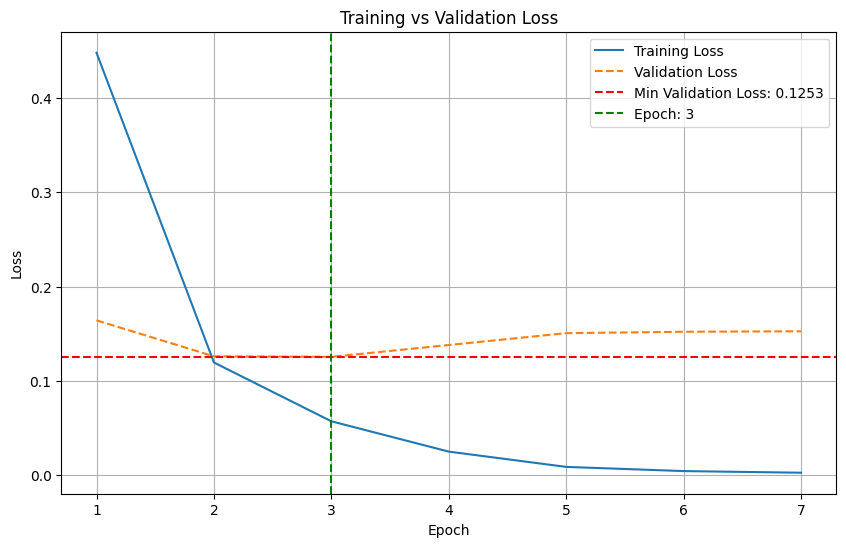

Macro-Averaged F1 Score: 0.5869

Micro-Averaged F1 Score: 0.7777

Weigthed-Averaged F1 Score: 0.7745

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.5000     0.0714     0.1250     14        

I-AND Gateway                       0.2500     0.1429     0.1818     7         

B-Activity                          0.7808     0.9344     0.8507     122       

I-Activity                          0.5000     0.5000     0.5000     6         

B-Activity Data                     0.7846     0.9107     0.8430     112       

I-Activity Data                     0.6457     0.8454     0.7321     97        

B-Actor                             0.8934     0.9237     0.9083     118       

I-Actor                             0.8197     0.9009     0.8584     111       

B-Condition Specification           0.7692     0.8333     0.8000     24        

I-Condition Specification           0.6000     0.7500     0.6667     24        

B-Furth

In [ ]:
learning_rates = [2e-5, 3e-5, 4e-5, 5e-5]
result_lr = {}

for lr in learning_rates:
    print("\n---------------------------------------")
    print(f"Learning Rate: {lr}")
    print("---------------------------------------\n")
    lr_model, avg_macro_f1, avg_micro_f1, avg_weight_f1, label_f1 = grouped_k_fold_cross_validation(input_data, 5, BATCH_SIZE, EPOCHS, label_map, lr)

    # Initialize the entry for this learning rate
    result_lr[lr] = {'avg_macro_f1': avg_macro_f1, 'avg_micro_f1':avg_micro_f1, 'avg_weight_f1': avg_weight_f1,  'label_f1': {}}

    for label, scores in label_f1.items():
        try:
            average_f1 = sum(scores) / len(scores)
            result_lr[lr]['label_f1'][label] = average_f1
        except ZeroDivisionError as zero:
            print(f"Zero division error for label {label}")

# Print the result to verify
print(result_lr)


We conclude from the print statements below and the graphs above that a learning rate of ```3e-05```is optimal for ```RoBERTa Large``` with an epoch of 4.

In [ ]:
for item in result_lr:
  print('Learning rate:', item)
  print('macro avg f1 for all folds: ', round(result_lr[item]['avg_macro_f1'],4))
  print('micro avg f1 for all folds: ', round(result_lr[item]['avg_micro_f1'],4))
  print('weighted avg f1 for all folds: ', round(result_lr[item]['avg_weight_f1'],4))
  for label, score in result_lr[item]['label_f1'].items():
    if label.startswith("B-AND") or label.startswith("I-AND"):
      print(label, round(score,2))
  print('----')

Learning rate: 2e-05
macro avg f1 for all folds:  0.5456
micro avg f1 for all folds:  0.723
weighted avg f1 for all folds:  0.7224
B-AND Gateway 0.16
I-AND Gateway 0.06
----
Learning rate: 3e-05
macro avg f1 for all folds:  0.6026
micro avg f1 for all folds:  0.751
weighted avg f1 for all folds:  0.7525
B-AND Gateway 0.27
I-AND Gateway 0.16
----
Learning rate: 4e-05
macro avg f1 for all folds:  0.5996
micro avg f1 for all folds:  0.7508
weighted avg f1 for all folds:  0.7521
B-AND Gateway 0.32
I-AND Gateway 0.2
----
Learning rate: 5e-05
macro avg f1 for all folds:  0.6181
micro avg f1 for all folds:  0.752
weighted avg f1 for all folds:  0.7535
B-AND Gateway 0.45
I-AND Gateway 0.11
----


Thus, below we use these hyperparameters and do a 5 fold crossvalidation.

Fold 1


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
Training...
Step 0, Loss: 2.5047, Precision: 0.8142, Recall: 0.9020, F1: 0.8558
Step 50, Loss: 0.1341, Precision: 0.9331, Recall: 0.9489, F1: 0.9401
Average training loss: 0.3325

Macro-Averaged F1 Score: 0.3288

Micro-Averaged F1 Score: 0.5596

Weigthed-Averaged F1 Score: 0.5374

Epoch 2/4
Training...
Step 0, Loss: 0.2391, Precision: 0.9437, Recall: 0.9481, F1: 0.9416
Step 50, Loss: 0.0485, Precision: 0.9536, Recall: 0.9549, F1: 0.9472
Average training loss: 0.1232

Macro-Averaged F1 Score: 0.4344

Micro-Averaged F1 Score: 0.6172

Weigthed-Averaged F1 Score: 0.5938

Epoch 3/4
Training...
Step 0, Loss: 0.1349, Precision: 0.9543, Recall: 0.9560, F1: 0.9483
Step 50, Loss: 0.0496, Precision: 0.9598, Recall: 0.9606, F1: 0.9559
Average training loss: 0.0537

Macro-Averaged F1 Score: 0.5393

Micro-Averaged F1 Score: 0.6768

Weigthed-Averaged F1 Score: 0.6738

Epoch 4/4
Training...
Step 0, Loss: 0.0523, Precision: 0.9600, Recall: 0.9607, F1: 0.9561
Step 50, Loss: 0.0058, Precision: 

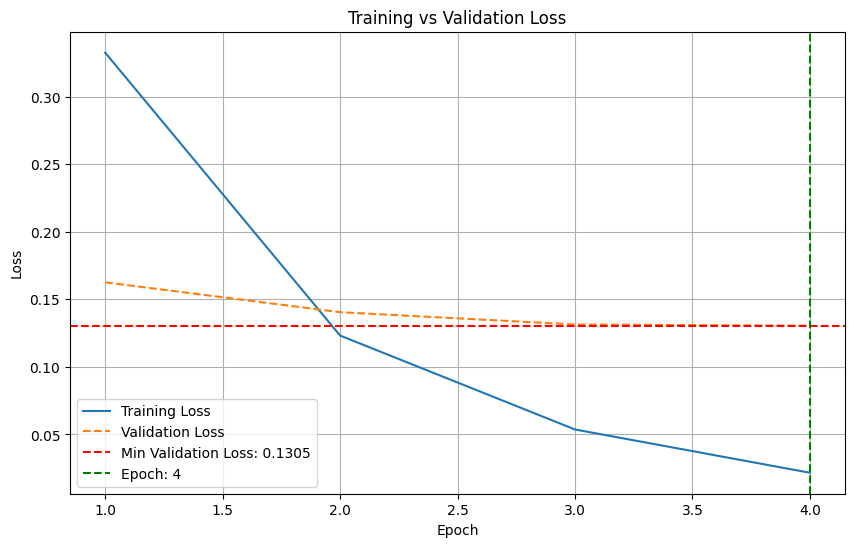

Macro-Averaged F1 Score: 0.5579

Micro-Averaged F1 Score: 0.6889

Weigthed-Averaged F1 Score: 0.6884

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.3333     0.1667     0.2222     6         

I-AND Gateway                       0.0000     0.0000     0.0000     0         

B-Activity                          0.8167     0.8596     0.8376     114       

I-Activity                          0.6667     0.4444     0.5333     9         

B-Activity Data                     0.7600     0.7525     0.7562     101       

I-Activity Data                     0.5702     0.6989     0.6280     93        

B-Actor                             0.7807     0.9368     0.8517     95        

I-Actor                             0.7303     0.8667     0.7927     75        

B-Condition Specification           0.8889     0.7273     0.8000     11        

I-Condition Specification           0.5833     0.6364     0.6087     11        

B-Furth

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
Training...
Step 0, Loss: 3.5064, Precision: 0.0029, Recall: 0.0259, F1: 0.0019
Step 50, Loss: 0.3094, Precision: 0.7977, Recall: 0.8932, F1: 0.8427
Average training loss: 0.5950

Macro-Averaged F1 Score: 0.0033

Micro-Averaged F1 Score: 0.0191

Weigthed-Averaged F1 Score: 0.0162

Epoch 2/4
Training...
Step 0, Loss: 0.4960, Precision: 0.7977, Recall: 0.8932, F1: 0.8427
Step 50, Loss: 0.2897, Precision: 0.8132, Recall: 0.8953, F1: 0.8498
Average training loss: 0.3389

Macro-Averaged F1 Score: 0.0050

Micro-Averaged F1 Score: 0.0296

Weigthed-Averaged F1 Score: 0.0247

Epoch 3/4
Training...
Step 0, Loss: 0.2975, Precision: 0.8185, Recall: 0.8971, F1: 0.8550
Step 50, Loss: 0.3632, Precision: 0.8173, Recall: 0.8965, F1: 0.8541
Average training loss: 0.3276

Macro-Averaged F1 Score: 0.0090

Micro-Averaged F1 Score: 0.0534

Weigthed-Averaged F1 Score: 0.0447

Epoch 4/4
Training...
Step 0, Loss: 0.2047, Precision: 0.8162, Recall: 0.8961, F1: 0.8532
Step 50, Loss: 0.3085, Precision: 

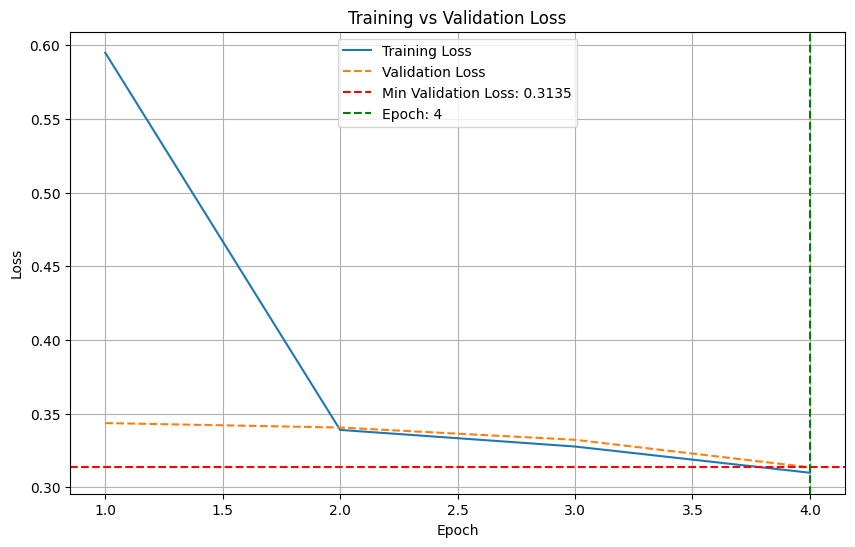

Macro-Averaged F1 Score: 0.0201

Micro-Averaged F1 Score: 0.1099

Weigthed-Averaged F1 Score: 0.0888

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     10        

I-AND Gateway                       0.0000     0.0000     0.0000     5         

B-Activity                          0.0000     0.0000     0.0000     125       

I-Activity                          0.0000     0.0000     0.0000     12        

B-Activity Data                     0.0000     0.0000     0.0000     122       

I-Activity Data                     0.0556     0.0431     0.0485     116       

B-Actor                             0.0000     0.0000     0.0000     122       

I-Actor                             0.0000     0.0000     0.0000     101       

B-Condition Specification           0.0000     0.0000     0.0000     17        

I-Condition Specification           0.0000     0.0000     0.0000     17        

B-Furth

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
Training...
Step 0, Loss: 1.6791, Precision: 0.8064, Recall: 0.8980, F1: 0.8497
Step 50, Loss: 0.2347, Precision: 0.9018, Recall: 0.9291, F1: 0.9115
Average training loss: 0.3596

Macro-Averaged F1 Score: 0.1737

Micro-Averaged F1 Score: 0.3627

Weigthed-Averaged F1 Score: 0.3248

Epoch 2/4
Training...
Step 0, Loss: 0.2209, Precision: 0.9078, Recall: 0.9285, F1: 0.9144
Step 50, Loss: 0.0860, Precision: 0.9436, Recall: 0.9560, F1: 0.9471
Average training loss: 0.1563

Macro-Averaged F1 Score: 0.4177

Micro-Averaged F1 Score: 0.6649

Weigthed-Averaged F1 Score: 0.6490

Epoch 3/4
Training...
Step 0, Loss: 0.1534, Precision: 0.9462, Recall: 0.9580, F1: 0.9508
Step 50, Loss: 0.0456, Precision: 0.9617, Recall: 0.9648, F1: 0.9623
Average training loss: 0.0787

Macro-Averaged F1 Score: 0.5595

Micro-Averaged F1 Score: 0.7220

Weigthed-Averaged F1 Score: 0.7194

Epoch 4/4
Training...
Step 0, Loss: 0.0756, Precision: 0.9619, Recall: 0.9652, F1: 0.9624
Step 50, Loss: 0.0106, Precision: 

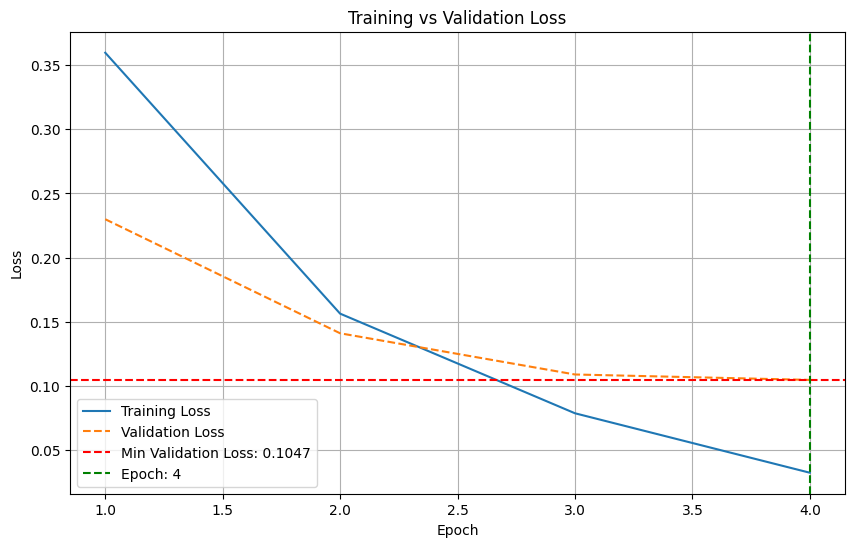

Macro-Averaged F1 Score: 0.5805

Micro-Averaged F1 Score: 0.7534

Weigthed-Averaged F1 Score: 0.7503

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     5         

I-AND Gateway                       0.0000     0.0000     0.0000     3         

B-Activity                          0.8296     0.9180     0.8716     122       

I-Activity                          1.0000     0.3333     0.5000     9         

B-Activity Data                     0.8182     0.8839     0.8498     112       

I-Activity Data                     0.6341     0.7800     0.6996     100       

B-Actor                             0.8571     0.9070     0.8814     86        

I-Actor                             0.7500     0.8675     0.8045     83        

B-Condition Specification           0.9130     0.7000     0.7925     30        

I-Condition Specification           0.6774     0.7241     0.7000     29        

B-Furth

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
Training...
Step 0, Loss: 2.7178, Precision: 0.2991, Recall: 0.0370, F1: 0.0606
Step 50, Loss: 0.3059, Precision: 0.8521, Recall: 0.9007, F1: 0.8660
Average training loss: 0.4687

Macro-Averaged F1 Score: 0.0483

Micro-Averaged F1 Score: 0.1207

Weigthed-Averaged F1 Score: 0.0851

Epoch 2/4
Training...
Step 0, Loss: 0.4972, Precision: 0.8670, Recall: 0.9090, F1: 0.8837
Step 50, Loss: 0.2061, Precision: 0.9278, Recall: 0.9439, F1: 0.9342
Average training loss: 0.2219

Macro-Averaged F1 Score: 0.3093

Micro-Averaged F1 Score: 0.5610

Weigthed-Averaged F1 Score: 0.5423

Epoch 3/4
Training...
Step 0, Loss: 0.1690, Precision: 0.9285, Recall: 0.9445, F1: 0.9351
Step 50, Loss: 0.0720, Precision: 0.9487, Recall: 0.9537, F1: 0.9503
Average training loss: 0.1179

Macro-Averaged F1 Score: 0.4280

Micro-Averaged F1 Score: 0.6423

Weigthed-Averaged F1 Score: 0.6371

Epoch 4/4
Training...
Step 0, Loss: 0.1366, Precision: 0.9494, Recall: 0.9541, F1: 0.9509
Step 50, Loss: 0.0650, Precision: 

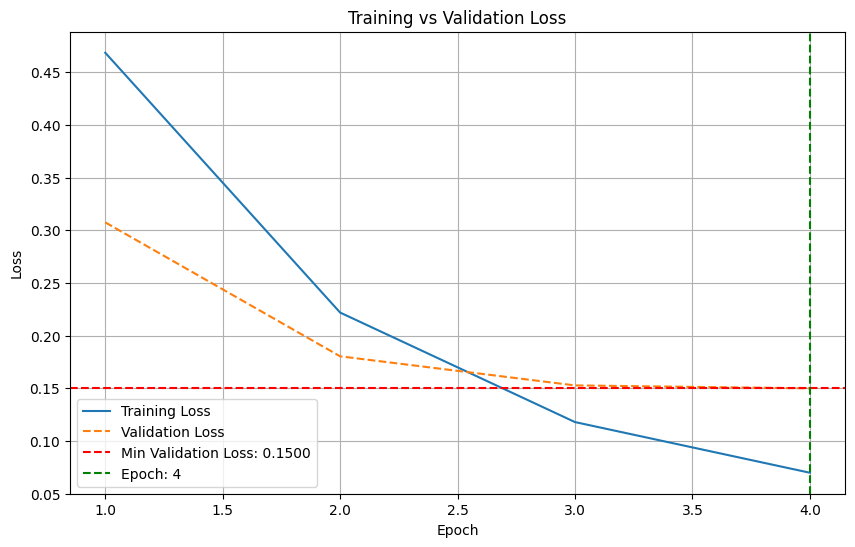

Macro-Averaged F1 Score: 0.4495

Micro-Averaged F1 Score: 0.6569

Weigthed-Averaged F1 Score: 0.6547

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     10        

I-AND Gateway                       0.0000     0.0000     0.0000     5         

B-Activity                          0.8000     0.7660     0.7826     141       

I-Activity                          0.0000     0.0000     0.0000     9         

B-Activity Data                     0.7373     0.7016     0.7190     124       

I-Activity Data                     0.5118     0.6075     0.5556     107       

B-Actor                             0.9223     0.7983     0.8559     119       

I-Actor                             0.8276     0.8000     0.8136     90        

B-Condition Specification           0.6522     0.6000     0.6250     25        

I-Condition Specification           0.5312     0.7391     0.6182     23        

B-Furth

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
Training...
Step 0, Loss: 2.2586, Precision: 0.8007, Recall: 0.8944, F1: 0.8450
Step 50, Loss: 0.2542, Precision: 0.9485, Recall: 0.9602, F1: 0.9524
Average training loss: 0.3130

Macro-Averaged F1 Score: 0.3718

Micro-Averaged F1 Score: 0.6821

Weigthed-Averaged F1 Score: 0.6629

Epoch 2/4
Training...
Step 0, Loss: 0.3979, Precision: 0.9470, Recall: 0.9593, F1: 0.9515
Step 50, Loss: 0.0929, Precision: 0.9643, Recall: 0.9607, F1: 0.9597
Average training loss: 0.1154

Macro-Averaged F1 Score: 0.4896

Micro-Averaged F1 Score: 0.7133

Weigthed-Averaged F1 Score: 0.7163

Epoch 3/4
Training...
Step 0, Loss: 0.1052, Precision: 0.9649, Recall: 0.9612, F1: 0.9602
Step 50, Loss: 0.0406, Precision: 0.9671, Recall: 0.9668, F1: 0.9654
Average training loss: 0.0490

Macro-Averaged F1 Score: 0.5379

Micro-Averaged F1 Score: 0.7478

Weigthed-Averaged F1 Score: 0.7470

Epoch 4/4
Training...
Step 0, Loss: 0.0501, Precision: 0.9668, Recall: 0.9667, F1: 0.9651
Step 50, Loss: 0.0303, Precision: 

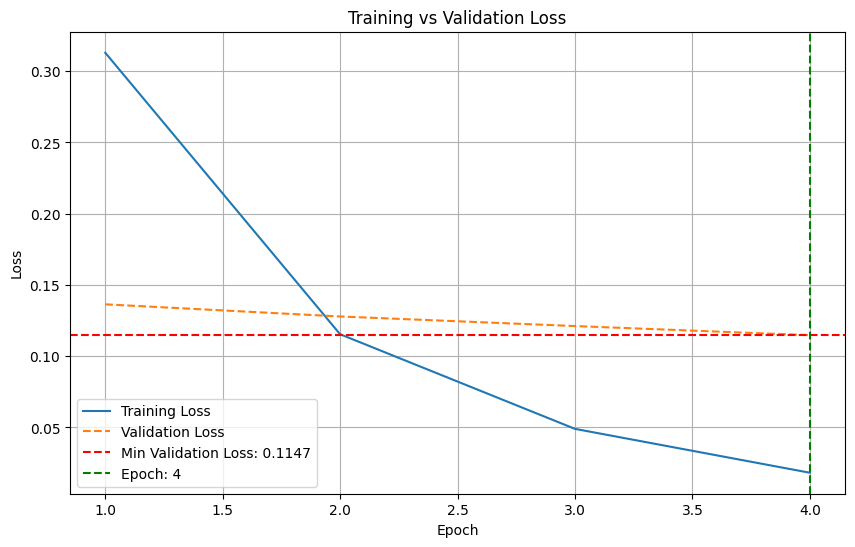

Macro-Averaged F1 Score: 0.5818

Micro-Averaged F1 Score: 0.7735

Weigthed-Averaged F1 Score: 0.7736

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.7500     0.3333     0.4615     9         

I-AND Gateway                       0.6000     0.5000     0.5455     6         

B-Activity                          0.8400     0.9459     0.8898     111       

I-Activity                          0.4286     0.6000     0.5000     5         

B-Activity Data                     0.8430     0.9358     0.8870     109       

I-Activity Data                     0.6780     0.8163     0.7407     98        

B-Actor                             0.8682     0.9333     0.8996     120       

I-Actor                             0.8197     0.9174     0.8658     109       

B-Condition Specification           0.6667     0.5333     0.5926     15        

I-Condition Specification           0.3333     0.4000     0.3636     15        

B-Furth

In [ ]:
epoch_best = 4
learning_rate = 5e-05
best_model, avg_macro_f1, avg_micro_f1, avg_weighted_f1, label_f1 = grouped_k_fold_cross_validation(input_data, 5, BATCH_SIZE, epoch_best, label_map, learning_rate)

#3. Model Saving for Pipeline

First we need to create a subset of the data to keep separate documents for testing. These documents are then also removed from the original training data before it goes through training.

##3.1.1 Remove 6 documents for testing


In [ ]:
#@title Training Model
def train_model_pipeline(input_data_pipeline, BATCH_SIZE, EPOCHS, label_map, learning_rate):
  # Training of the model
  # Instantiate the dataset and dataloader for validation
  train_data, val_data = train_test_split(input_data_pipeline, test_size=0.2, random_state=SEED)

  train_dataset = NERDataset(
      sentences=[entry['tokens'] for entry in train_data],
      labels=[entry['ner-tags'] for entry in train_data],
      tokenizer=tokenizer,
      max_len=MAX_LEN,
      label_map=label_map
  )
  # Instantiate the dataset and dataloader for validation
  val_dataset = NERDataset(
      sentences=[entry['tokens'] for entry in val_data],
      labels=[entry['ner-tags'] for entry in val_data],
      tokenizer=tokenizer,
      max_len=MAX_LEN,
      label_map=label_map
  )

  #Initialize the DataLoader objects
  train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

  #loading the desired model: each fold we need start fresh
  model = RobertaForTokenClassification.from_pretrained("roberta-large", num_labels=NUM_LABELS)

  # Fine-tuning setup, can be changed for model optimisation
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
  total_steps = len(train_loader) * EPOCHS
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

  # Using funtion defined above to train the model and obtain the losses for plotting at the same time
  model, training_losses, validation_losses = train_model(model, train_loader, val_loader, optimizer, scheduler, EPOCHS, label_map)
  plot_losses(training_losses,validation_losses)

  #Evaluating the model in this fold
  val_metrics = evaluate_model(model, val_loader, label_map)

  #So it is printed pretty :)
  header = "{:<35} {:<10} {:<10} {:<10}\n".format("Label", "Precision", "Recall", "F1")
  row_format = "{:<35} {:<10} {:<10} {:<10}\n"
  print(header)
  for label, metrics in val_metrics['detailed_metrics'].items():
    print(row_format.format(label, "{:.4f}".format(metrics['precision']), "{:.4f}".format(metrics['recall']), "{:.4f}".format(metrics['f1'])))

  # Now, label_f1_scores[label] holds a list of F1 scores for that label across all folds
  return model

{'doc-3.1', 'doc-8.2', 'doc-10.7', 'doc-9.3', 'doc-10.12', 'doc-20.5 - edit pictures'}
data loaded


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
Training...
Step 0, Loss: 2.9786, Precision: 0.8070, Recall: 0.8694, F1: 0.8346
Step 47, Loss: 0.1992, Precision: 0.9257, Recall: 0.9381, F1: 0.9249
Average training loss: 0.4272

Macro-Averaged F1 Score: 0.2630

Micro-Averaged F1 Score: 0.5301

Weigthed-Averaged F1 Score: 0.5010

Epoch 2/4
Training...
Step 0, Loss: 0.2990, Precision: 0.9306, Recall: 0.9367, F1: 0.9291
Step 47, Loss: 0.1179, Precision: 0.9601, Recall: 0.9633, F1: 0.9609
Average training loss: 0.1358

Macro-Averaged F1 Score: 0.4632

Micro-Averaged F1 Score: 0.6788

Weigthed-Averaged F1 Score: 0.6814

Epoch 3/4
Training...
Step 0, Loss: 0.0967, Precision: 0.9605, Recall: 0.9584, F1: 0.9582
Step 47, Loss: 0.0204, Precision: 0.9614, Recall: 0.9650, F1: 0.9623
Average training loss: 0.0725

Macro-Averaged F1 Score: 0.5188

Micro-Averaged F1 Score: 0.7088

Weigthed-Averaged F1 Score: 0.7063

Epoch 4/4
Training...
Step 0, Loss: 0.1274, Precision: 0.9610, Recall: 0.9642, F1: 0.9617
Step 47, Loss: 0.0287, Precision: 

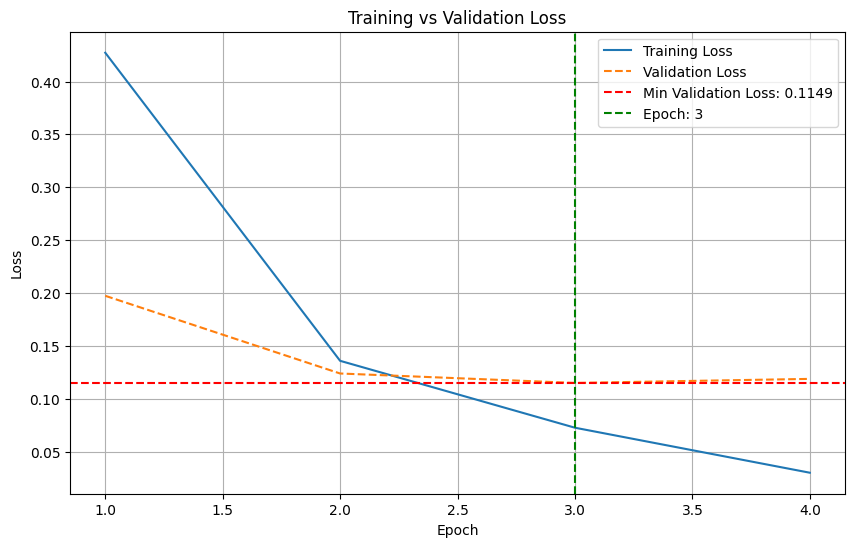

Macro-Averaged F1 Score: 0.5637

Micro-Averaged F1 Score: 0.7283

Weigthed-Averaged F1 Score: 0.7246

Label                               Precision  Recall     F1        

I-Further Specification             0.2857     0.5333     0.3721    

I-Condition Specification           0.4815     0.6500     0.5532    

B-XOR Gateway                       0.8571     0.7742     0.8136    

I-AND Gateway                       0.0000     0.0000     0.0000    

I-Actor                             0.7526     0.8902     0.8156    

I-XOR Gateway                       1.0000     0.2500     0.4000    

B-Further Specification             0.8571     0.3333     0.4800    

B-Activity                          0.7669     0.8947     0.8259    

B-Condition Specification           0.7778     0.6667     0.7179    

B-AND Gateway                       0.0000     0.0000     0.0000    

B-Actor                             0.8246     0.9400     0.8785    

B-Activity Data                     0.7913     0.8505     

In [ ]:
def pick_and_remove_documents(data, num_docs, SEED):
    # Pick 6 documents at random
    random.seed(SEED)
    selected_docs_indices = random.sample(range(len(data)), num_docs)
    selected_docs = [data[i] for i in selected_docs_indices]

    # Remove the selected documents from the original data
    remaining_docs = [doc for i, doc in enumerate(data) if i not in selected_docs_indices]

    return selected_docs, remaining_docs

try:

  selected_docs, remaining_docs = pick_and_remove_documents(unflattened_data, 6, SEED)
  folder_path = '/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/TESTING DATA/NER_TESTING/'

  check= set()
  for document in selected_docs:
    for sentence in document:
      check.add(sentence['document name'])
  print(check)

  # here the selected documents are saved for pipeline testing
  for i, document in enumerate(selected_docs):
        file_path = os.path.join(folder_path, f'document_{i+1}.json')
        with open(file_path, 'w') as file:
            for sentence in document:
                # Convert the sentence to a JSON string and write it with a newline
                json_line = json.dumps(sentence) + '\n'
                file.write(json_line)

  input_data_pipeline = [item for group in remaining_docs for item in group]

  if input_data_pipeline:
    print('data loaded')

  #training of the model without the 6 left out documents
  epochs_pipe= 4 #TODO
  lr= 5e-05
  model2 = train_model_pipeline(input_data_pipeline, BATCH_SIZE, epochs_pipe, label_map, lr)

except FileNotFoundError as fnf:
  print("File was not found or incorrect file directory, please try to run cell again")

##3.1.2 Training BERT on full data

Based on the testing on proper learning rates and looking at the loss graphs we set the epochs to 5 and the lr to ```5e-05```.

##3.2 Training and saving the model



In [ ]:
# Save the model to a file
# Assuming 'best_model' is your trained model and 'tokenizer' is your tokenizer
model_path = "/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/PIPELINE/NER MODELS/RoBERTa_Large/6DOCLEFTOUT/MODEL/"
tokenizer_path = "/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/PIPELINE/NER MODELS/RoBERTa_Large/6DOCLEFTOUT/TOKENIZER/"

# Save the model & tokenizer
model2.save_pretrained(model_path)
tokenizer.save_pretrained(tokenizer_path)

('/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/PIPELINE/NER MODELS/RoBERTa_Large/6DOCLEFTOUT/TOKENIZER/tokenizer_config.json',
 '/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/PIPELINE/NER MODELS/RoBERTa_Large/6DOCLEFTOUT/TOKENIZER/special_tokens_map.json',
 '/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/PIPELINE/NER MODELS/RoBERTa_Large/6DOCLEFTOUT/TOKENIZER/vocab.json',
 '/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/PIPELINE/NER MODELS/RoBERTa_Large/6DOCLEFTOUT/TOKENIZER/merges.txt',
 '/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/PIPELINE/NER MODELS/RoBERTa_Large/6DOCLEFTOUT/TOKENIZER/added_tokens.json')